### Предсказание Customer Lifetime Value для игры Ghost Town Adventures

В ходе учебной практики в компании Webgames мной решалась задача предсказания LTV (lifetime value, пожизненной стоимости клиента) на основе предоставленных пользовательских данных приложения Ghost Town Adventures для мобильной платформы Android. Расчёт данной метрики для пользователя позволяет предсказать, какую прибыль от него следует ожидать, и соответствующим способом модифицировать возможные предложения по скидкам для внутриигровых покупок, а также адаптировать иные возможные траты. 

Так как вычисление персонализированного LTV с учетом сведений об игроке можно сформулировать как задачу регрессии (зависимой переменной в данном случае является прибыль от игрока за весь период или некий значительный промежуток времени с момента регистрации, независимыми — данные за первые несколько дней после установки игры), было принято решение применить различные методы машинного обучения, созданные для решения регрессии, а затем сравнить качество обученных моделей для выбора лучшей. В процессе работы над задачей использовались файлы со следующими данными:


```practice_dau_and``` — ежедневные сообщения с устройства игрока
* id - идентификатор игрока
* сountry - страна
* number_of_pgr - количество PGR-сообщений (их шлет устройство во время игры)
* actdate - дата события

```practice_pact_and``` — агрегированные данные о деятельности игрока в этот день
* id - идентификатор игрока
* actdate - дата события
* regdate - дата регистрации игрока
* clusters_ml_ended - сколько кластеров (кластеры состоят из квестов) основной сюжетной линии прошел игрок
* revenue - прибыль с игрока
* transactions - количество платежей;
* quests_end - сколько побочных квестов прошел игрок
* m_quests_end - сколько квестов основной сюжетной линии прошел игрок
* crystals_value_spend - сколько кристаллов (в определенной нормировке) потратил игрок
* store_enters - сколько раз игрок зашел в магазин

Для оценки моделей главным образом использовались следующие метрики:
* RMSE — Root Mean Squared Error
* MAE — Mean Absolute Error

Также качество предсказания сравнивалось следующим образом: из всей выборки выделялась в тестовую информация по пользователям, зарегистрировавшимся с 13 по 19 февраля 2017 года (данные по игрокам, зарегистрировавшимся до этого, соответственно, являлись обучающей выборкой), чтобы можно было оценить предсказание LTV за наиболее долгий период (100 дней), затем все предсказания модели по каждому из пользователей и дней недели суммировались и сравнивались с действительными показателями.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
from itertools import product
from sklearn.preprocessing import LabelEncoder
from datetime import timedelta
import gc
from sklearn.metrics import mean_squared_error, mean_absolute_error
from lightgbm import LGBMRegressor, early_stopping
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
import lightgbm
import sklearn
from multiprocessing import Pool, cpu_count
from functools import partial
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['savefig.dpi'] = 400

При предварительной обработке данных были удалены строки-дубликаты из таблицы ```practice_dau_and``` (из двух записей о пользователе в один и тот же день выбиралась запись с большим числом PGR-сообщений), а также столбцы ```crystals_value_spend``` и ```store_enters``` (так как они содержали только значения 0) из таблицы ```practice_pact_and```. Помимо этого была изменена дата регистрации для каждого пользователя на наиболее раннюю (повторная установка приложения считалась повторной регистрацией). Для уменьшения занимаемой памяти категориальные признаки ```country``` и ```id``` преобразовывались в целочисленные с помощью ```LabelEncoder```.

In [2]:
dau=pd.read_csv("practice_dau_and.csv",sep="|",header=None,engine="c",names=["id","country","number_of_pgr","actdate"],
                dtype={"number_of_pgr":"int16"},
                parse_dates=[3],na_filter=False).sort_values(by=["id","actdate","number_of_pgr"]).drop_duplicates(
    subset=["id","actdate"],keep="last")
pact=pd.read_csv("practice_pact_and.csv",sep="|",header=None,engine="c",names=
                ["id","actdate","regdate","clusters_ml_ended","revenue","transactions","quests_end","m_quests_end",
                "crystals_value_spend","store_enters"],usecols=["id","actdate","regdate","clusters_ml_ended",
                "revenue","transactions","quests_end","m_quests_end"],dtype={"clusters_ml_ended":"int8",
                "revenue":"float32","transactions":"int8","quests_end":"int16","m_quests_end":"int16"},
                 parse_dates=[1,2])
pact=pact.drop("regdate",axis=1).join(pact.groupby("id").regdate.min().to_frame(),on="id")
pact=pd.merge(dau,pact,on=["id","actdate"],copy=False)
lenc_cntr=LabelEncoder()
lenc_id=LabelEncoder()
pact.country=lenc_cntr.fit_transform(pact.country.values).astype("uint8")
pact.id=lenc_cntr.fit_transform(pact.id.values).astype("uint32")
del dau

Всё преобразование данных для деления на обучающую и тестовую выборки в вид, в котором одному пользователю сопоставляется вектор признаков
описано в функции split_data:
    
* ```pact``` — исходная таблица с объединёнными данными из двух источников, прошедшими предварительную очистку
* ```days_obs``` — число дней, по наблюдению за которые проводились предсказания
* ```days_pred``` — число дней, по наблюдению за которые рассчитывалась прибыль с пользователя
* ```threshold``` — порог, по превышению которого прибыль (как за конкретный день, так и по окончанию периода наблюдений) становилась равной значению параметра

Были сформированы следующие признаки для каждого пользователя:

* ```country``` — страна регистрации пользователя
* ```number_of_pgr{}```, ```clusters_ml_ended{}```, ```revenue{}```, ```transactions{}```, ```quests_end{}```, ```m_quests_end{}```, ```actmonth{}```, ```actday{}``` — соответствующие данные из исходных файлов для каждого из ```days_obs``` дней с момента регистрации, по которым производилось наблюдение для последующего предсказания прибыли
* ```revenue``` — итоговая прибыль от пользователя по истечении ```days_pred``` дней, предсказываемый признак

Также на основе имеющихся данных были построены дополнительные признаки (```extra_features```):

* Среднее арифметическое, медиана, минимум, максимум и стандартное отклонение прибыли за период наблюдений
* Число дней, в которые прибыль была ненулевой, а также доля таких дней от общего срока

In [74]:
def split_data(pact,days_obs,days_pred,testweek=False,threshold=1000,extra_features=False,earlier_split=False):
    y=pact[(pact.actdate-pact.regdate)<=timedelta(days=days_pred-1)].groupby("id").revenue.sum().to_frame()
    y.loc[y.revenue>threshold,"revenue"]=threshold
    pact_train=pact[(pact.actdate-pact.regdate)<=timedelta(days=days_obs-1)].copy()
    pact_train.loc[pact_train.revenue>threshold,"revenue"]=threshold
    pact_train["day"]=((pact_train["actdate"]-pact_train["regdate"])/np.timedelta64(1, 'D')).astype("int8")
    pact_train=pact_train.set_index(["id","day"]).reindex(pd.MultiIndex.from_product([pact_train["id"].unique(), range(days_obs)], names=["id", "day"]))
    pact_train.regdate.fillna(method="ffill",inplace=True)
    pact_train.country.fillna(method="ffill",inplace=True)
    pact_train.actdate=pd.to_timedelta(pact_train.index.get_level_values(level=1),"d")+pact_train.regdate
    pact_train.fillna(0,inplace=True)
    pact_train["regmonth"]=pact_train.regdate.dt.month
    pact_train["regday"]=pact_train.regdate.dt.day
    pact_train["actmonth"]=pact_train.actdate.dt.month
    pact_train["actday"]=pact_train.actdate.dt.day
    pact_train=pact_train.drop(["regdate","actdate"],axis=1).unstack().drop(
        [col for col in product(["regmonth","regday","country"],range(1,days_obs))],axis=1)
    pact_train[[("country",0)]+[col for col in product(["transactions","actmonth","actday"],range(days_obs))]]=pact_train[[
    ("country",0)]+[col for col in product(["transactions","actmonth","actday"],range(days_obs))]].astype("uint8")
    pact_train[[col for col in product(["clusters_ml_ended"],range(days_obs))]]=pact_train[
        [col for col in product(["clusters_ml_ended"],range(days_obs))]].astype("int8")
    pact_train[[col for col in product(["revenue"],range(days_obs))]]=pact_train[
        [col for col in product(["revenue"],range(days_obs))]].astype("float32")
    pact_train[[col for col in product(["number_of_pgr","quests_end","m_quests_end"],range(days_obs))]]=pact_train[[
        col for col in product(["number_of_pgr","quests_end","m_quests_end"],range(days_obs))]].astype("int16")
    pact_train.columns=["".join(map(str,col)) for col in pact_train.columns]
    pact_train.rename(columns={"regmonth0":"regmonth","regday0":"regday","country0":"country"},inplace=True)
    pact_train.index.name=None
    if extra_features:
        pact_train["rev_min"]=np.min(pact_train[["revenue"+str(i) for i in range(days_obs)]],axis=1)
        pact_train["rev_max"]=np.max(pact_train[["revenue"+str(i) for i in range(days_obs)]],axis=1)
        pact_train["rev_mean"]=np.mean(pact_train[["revenue"+str(i) for i in range(days_obs)]],axis=1)
        pact_train["rev_median"]=np.median(pact_train[["revenue"+str(i) for i in range(days_obs)]],axis=1)
        pact_train["rev_std"]=np.std(pact_train[["revenue"+str(i) for i in range(days_obs)]],axis=1)
        pact_train["rev_nonzero"]=np.count_nonzero(pact_train[["revenue"+str(i) for i in range(days_obs)]],axis=1)
        pact_train["frac_zero"]=1-pact_train["rev_nonzero"]/days_obs
    cleaned=pd.merge(pact_train,y,left_index=True,right_index=True)
    if testweek:
        train=cleaned[(cleaned.regmonth==1)|((cleaned.regmonth==2)&(cleaned.regday<13))]
        test=[cleaned[(cleaned.regmonth==2)&(cleaned.regday==day)] for day in range(13,20)]
        return train,test
    elif earlier_split:
        train=cleaned[cleaned.regmonth<3]
        test=cleaned[cleaned.regmonth>=3]
        return train,test
    else:
        train=cleaned[(cleaned.regmonth<3)|((cleaned.regmonth==3)&(cleaned.regday<17))]
        test=cleaned[~((cleaned.regmonth<3)|((cleaned.regmonth==3)&(cleaned.regday<17)))]
        return train,test

В процессе решения задачи сравнивались следующие модели: LightGBM Regressor из библиотеки LightGBM, RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor (алгоритмы, основанные на случайных лесах либо бустинге над решающими деревьями), ElasticNetCV (линейная модель с L1- и L2-регуляризацией) из библиотеки scikit-learn.

Функция get_models_scores оценивает каждую из моделей на одинаковых выборках для каждого из периодов и возвращает DataFrame с результатами по метрикам RMSE и MAE, а также по сумме предсказаний для зарегистрировавшихся 1 мая пользователей, а также параллельно строит графики важности признаков для лучшей по RMSE модели для данного периода.

In [4]:
def fit(regr,X,y):
    return regr.fit(X,y)

def get_models_scores(pact,days_obs,days_pred):
    print("Timestamp:",datetime.datetime.now().strftime("%d %b %H:%M:%S"),"Time period:",str(days_obs)+"-"+str(days_pred))
    train,test=split_data(pact,days_obs,days_pred)
    regr1=LGBMRegressor(n_estimators=100,seed=100)
    regr2=ElasticNet(random_state=100)
    regr3=RandomForestRegressor(random_state=100)
    regr4=ExtraTreesRegressor(random_state=100)
    regr5=GradientBoostingRegressor(subsample=0.85,random_state=100)
    x_train,y_train=train.drop("revenue",axis=1),train.revenue
    x_test,y_test=test.drop("revenue",axis=1),test.revenue
    regr1.fit(x_train,y_train)
    with Pool(processes=cpu_count()) as p:
        regr2,regr3,regr4,regr5=p.map(partial(fit,X=x_train,y=y_train),[regr2,regr3,regr4,regr5])
    oneday=test[(test.regmonth==5)&(test.regday==1)]
    true_sum=oneday.revenue.sum()
    mse_results=[mean_squared_error(y_test,regr.predict(x_test)) for regr in [regr1,regr2,regr3,regr4,regr5]]
    best=np.argmin(mse_results)
    best_regr=[regr1,regr2,regr3,regr4,regr5][best]
    if best==2:
        inds=np.argsort(best_regr.coef_)[-10:][::-1]
        sns.barplot(best_regr.coef_[inds],x_train.columns[inds])
    else:
        inds=np.argsort(best_regr.feature_importances_)[-10:][::-1]
        sns.barplot(best_regr.feature_importances_[inds],x_train.columns[inds])
    plt.show()
    mae_results=[mean_absolute_error(y_test,regr.predict(x_test)) for regr in [regr1,regr2,regr3,regr4,regr5]]
    oneday_results=[regr.predict(oneday.drop("revenue",axis=1)).sum() for regr in [regr1,regr2,regr3,regr4,regr5]]
    return [pd.DataFrame(np.sqrt(np.array(mse_results+[np.mean(np.square(test.revenue))])).reshape(1,6),
            index=[str(days_obs)+"-"+str(days_pred)],columns=["LightGBM","ElasticNet","RandomForestRegressor",
            "ExtraTreesRegressor","GradientBoostingRegressor","RMS of revenues"]),
            pd.DataFrame(np.array(mae_results+[np.mean(test.revenue)]).reshape(1,6),index=[
            str(days_obs)+"-"+str(days_pred)],columns=["LightGBM","ElasticNet","RandomForestRegressor",
            "ExtraTreesRegressor","GradientBoostingRegressor","Mean of revenues"]),
            pd.DataFrame(np.array(oneday_results+[true_sum]).reshape(1,6),index=[
            str(days_obs)+"-"+str(days_pred)],columns=["LightGBM","ElasticNet","RandomForestRegressor",
            "ExtraTreesRegressor","GradientBoostingRegressor","True sum"])
           ]

def get_week_results(pact,days_obs,days_pred):
    print("Timestamp:",datetime.datetime.now().strftime("%d %b %H:%M:%S"),"Time period:",str(days_obs)+"-"+str(days_pred))
    train,test=split_data(pact,days_obs,days_pred,testweek=True)
    regr1=LGBMRegressor(n_estimators=100,seed=100)
    regr2=ElasticNet(random_state=100)
    regr3=RandomForestRegressor(random_state=100)
    regr4=ExtraTreesRegressor(random_state=100)
    regr5=GradientBoostingRegressor(subsample=0.85,random_state=100)
    x_train,y_train=train.drop("revenue",axis=1),train.revenue
    regr1.fit(x_train,y_train)
    with Pool(processes=cpu_count()) as p:
        regr2,regr3,regr4,regr5=p.map(partial(fit,X=x_train,y=y_train),[regr2,regr3,regr4,regr5])
    return [pd.DataFrame(np.array([regr.predict(test[day].drop("revenue",axis=1)).sum() for regr in [regr1,regr2,regr3,regr4,
            regr5]]+[test[day].revenue.sum()]).reshape(1,6),index=[str(days_obs)+"-"+str(days_pred)],columns=["LightGBM",
            "ElasticNet","RandomForestRegressor","ExtraTreesRegressor","GradientBoostingRegressor","True sum"]
                        ) for day in range(7)]

Ниже приведены графики важности топ-10 признаков для лучшей модели (в случае линейной модели важностью считалась величина коэффициента), а также качество моделей при оценивании на данных с периодами наблюдения-предсказания, состоящими из всех возможных комбинаций 3,7 и 15 дней, по которым производилось наблюдение, и 15,30,60 и 100 дней, по истечении которых рассчитывался показатель LTV для пользователя.

Timestamp: 28 Jul 23:04:52 Time period: 3-15


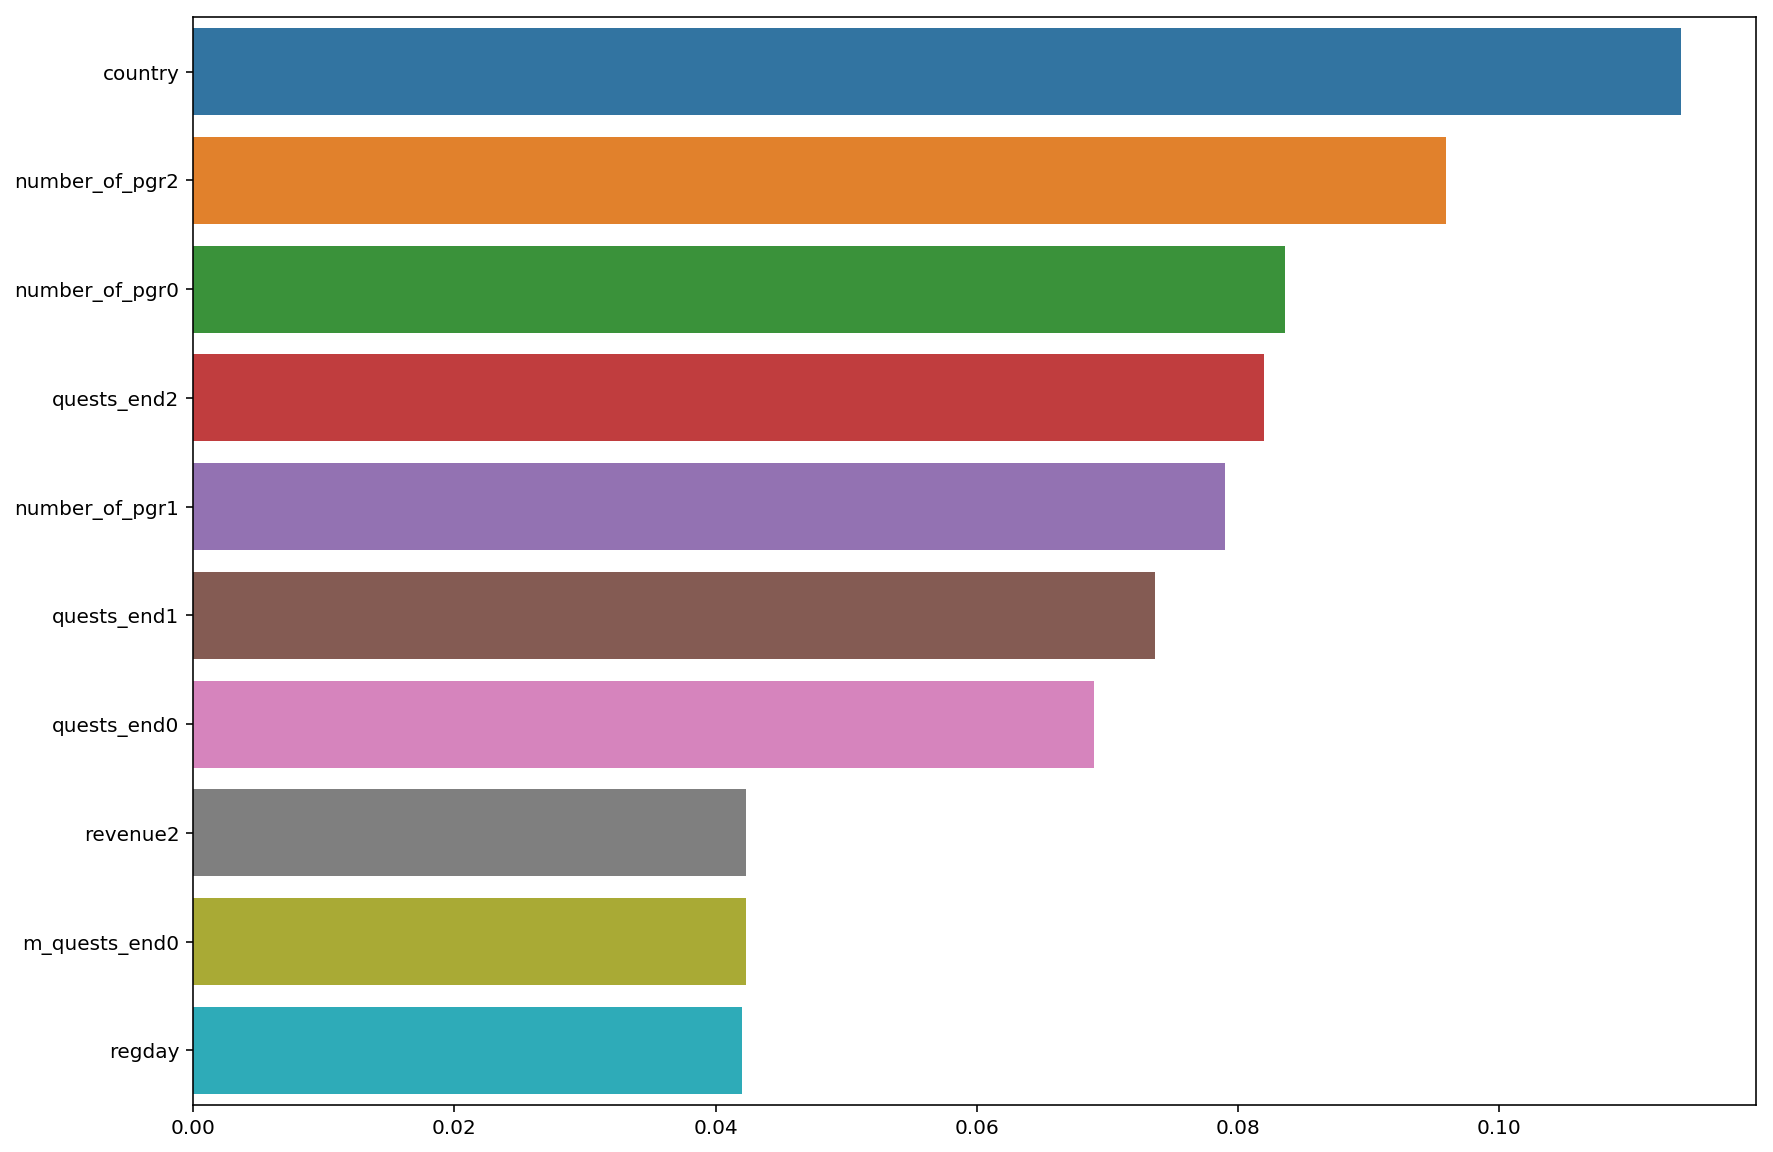

Timestamp: 28 Jul 23:11:00 Time period: 3-30


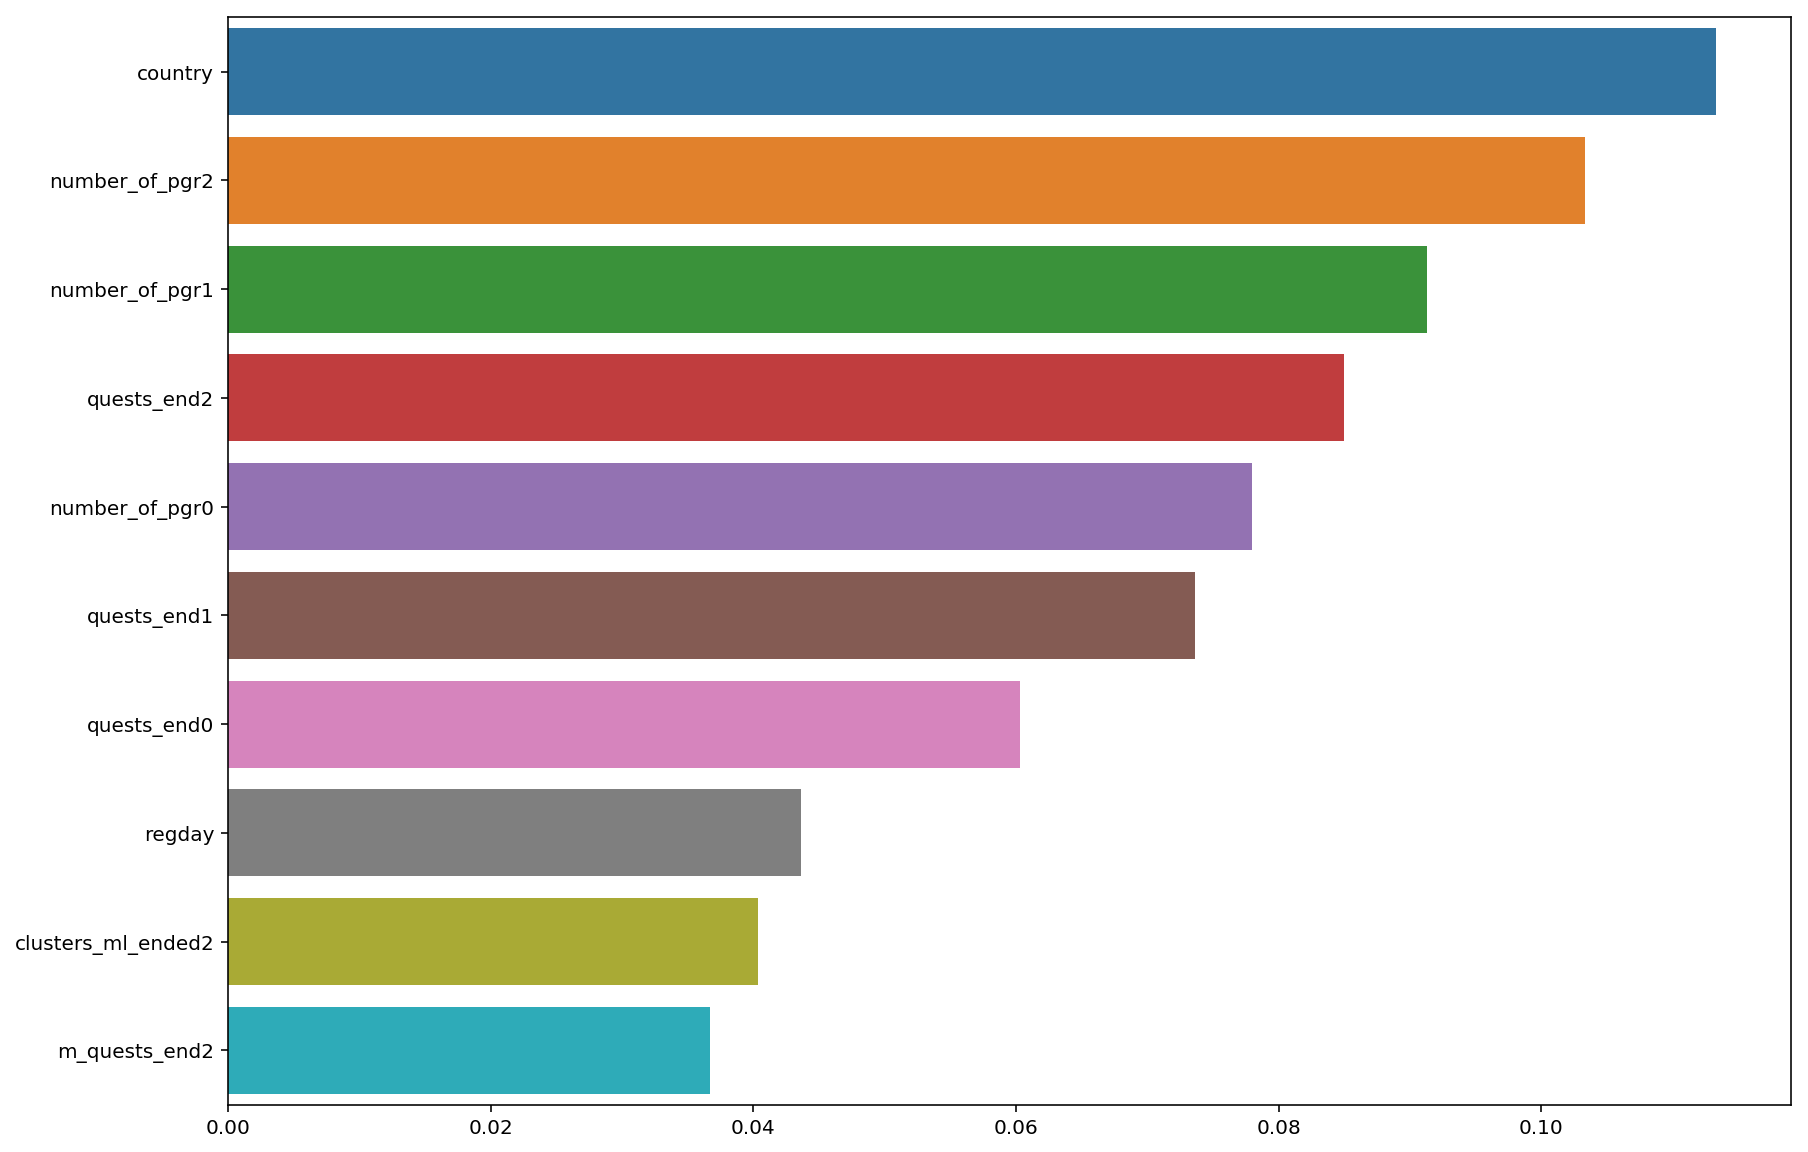

Timestamp: 28 Jul 23:17:10 Time period: 3-60


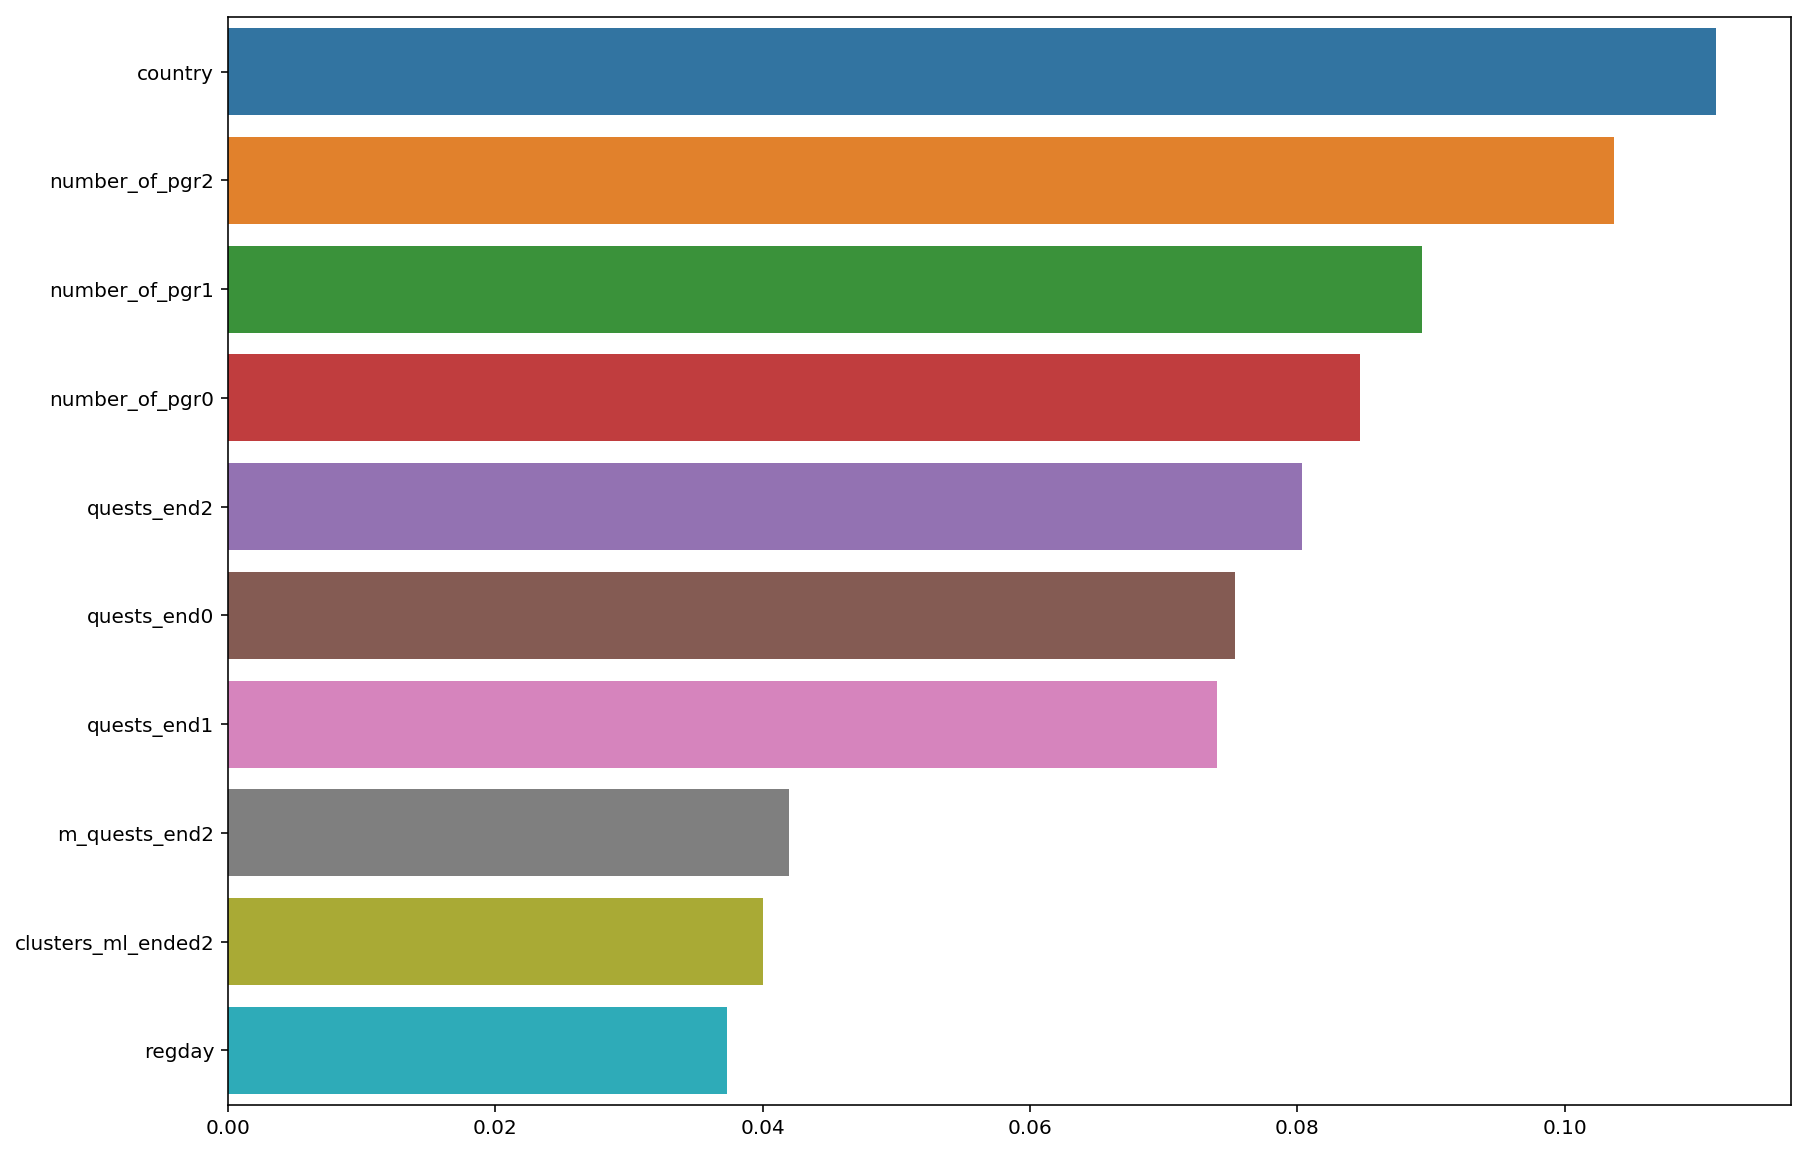

Timestamp: 28 Jul 23:23:22 Time period: 3-100


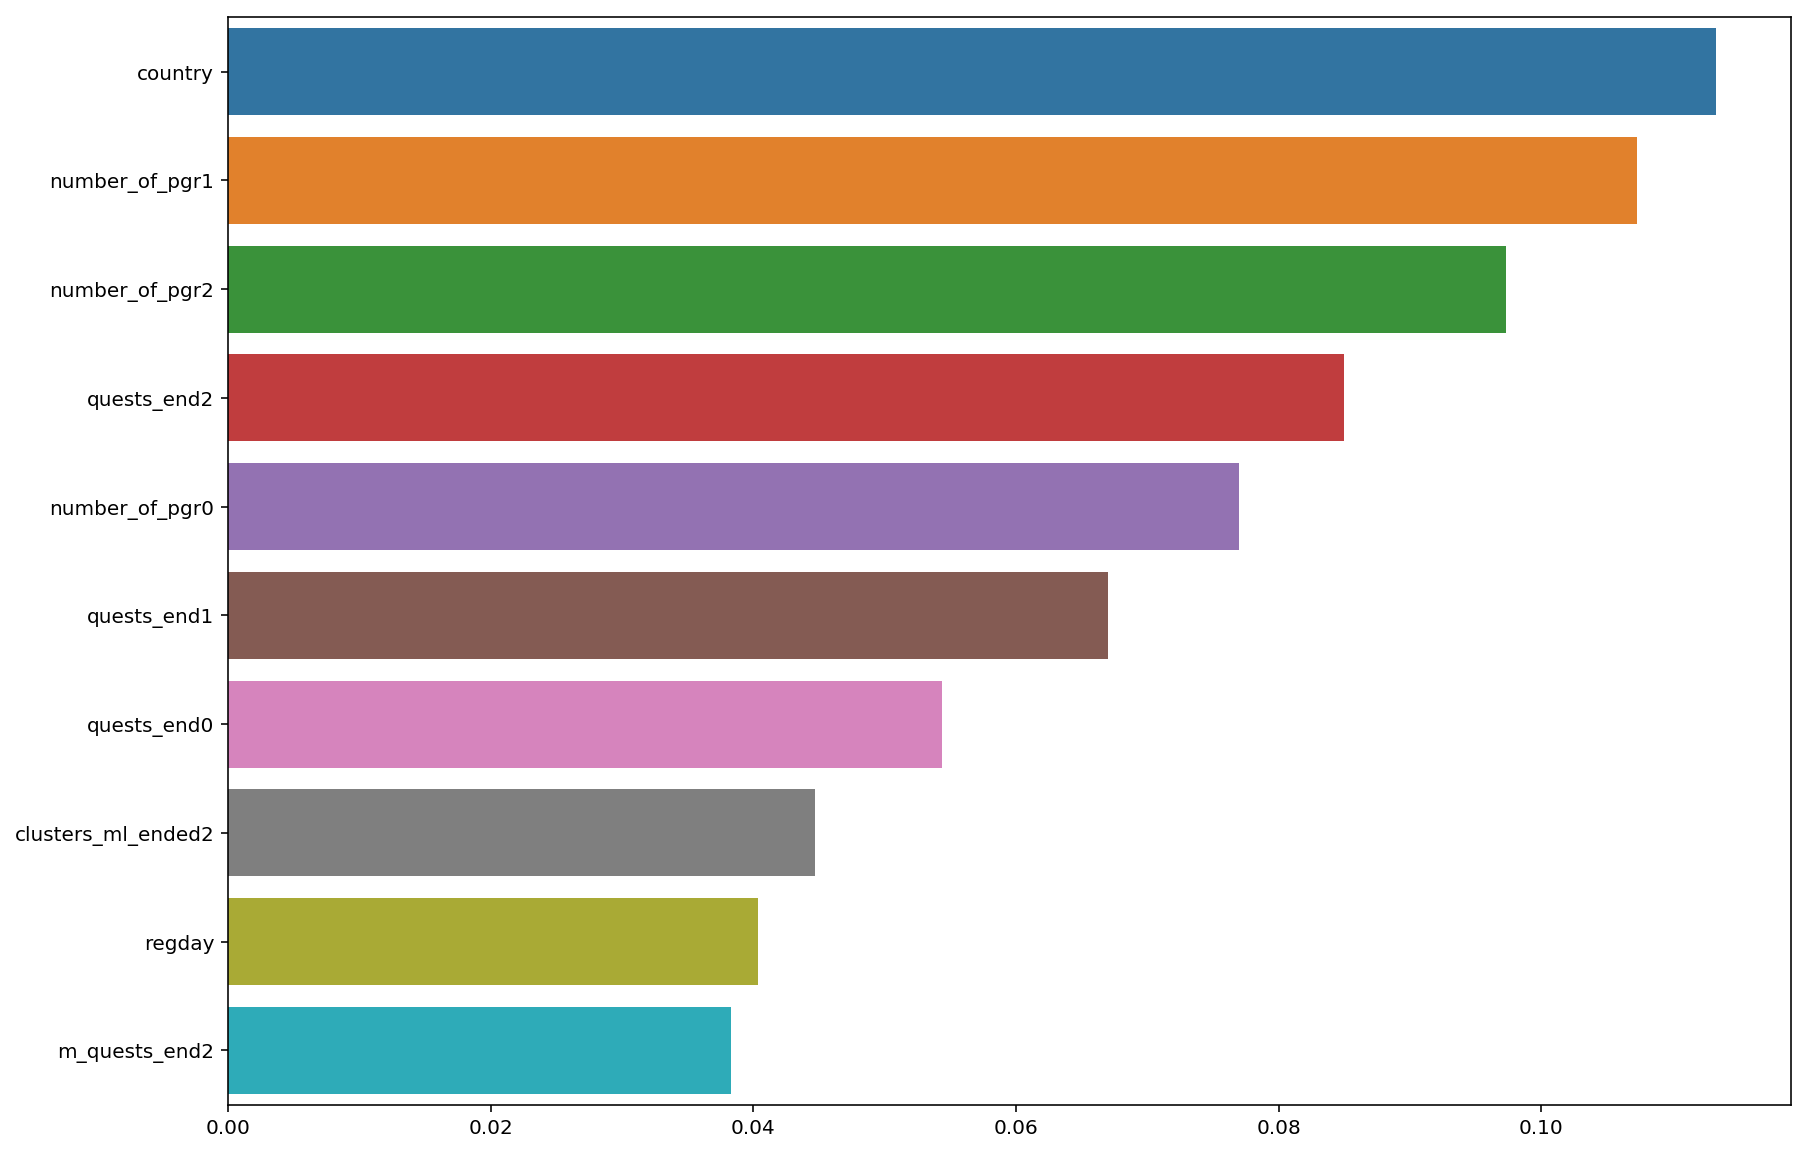

Timestamp: 28 Jul 23:29:33 Time period: 7-15


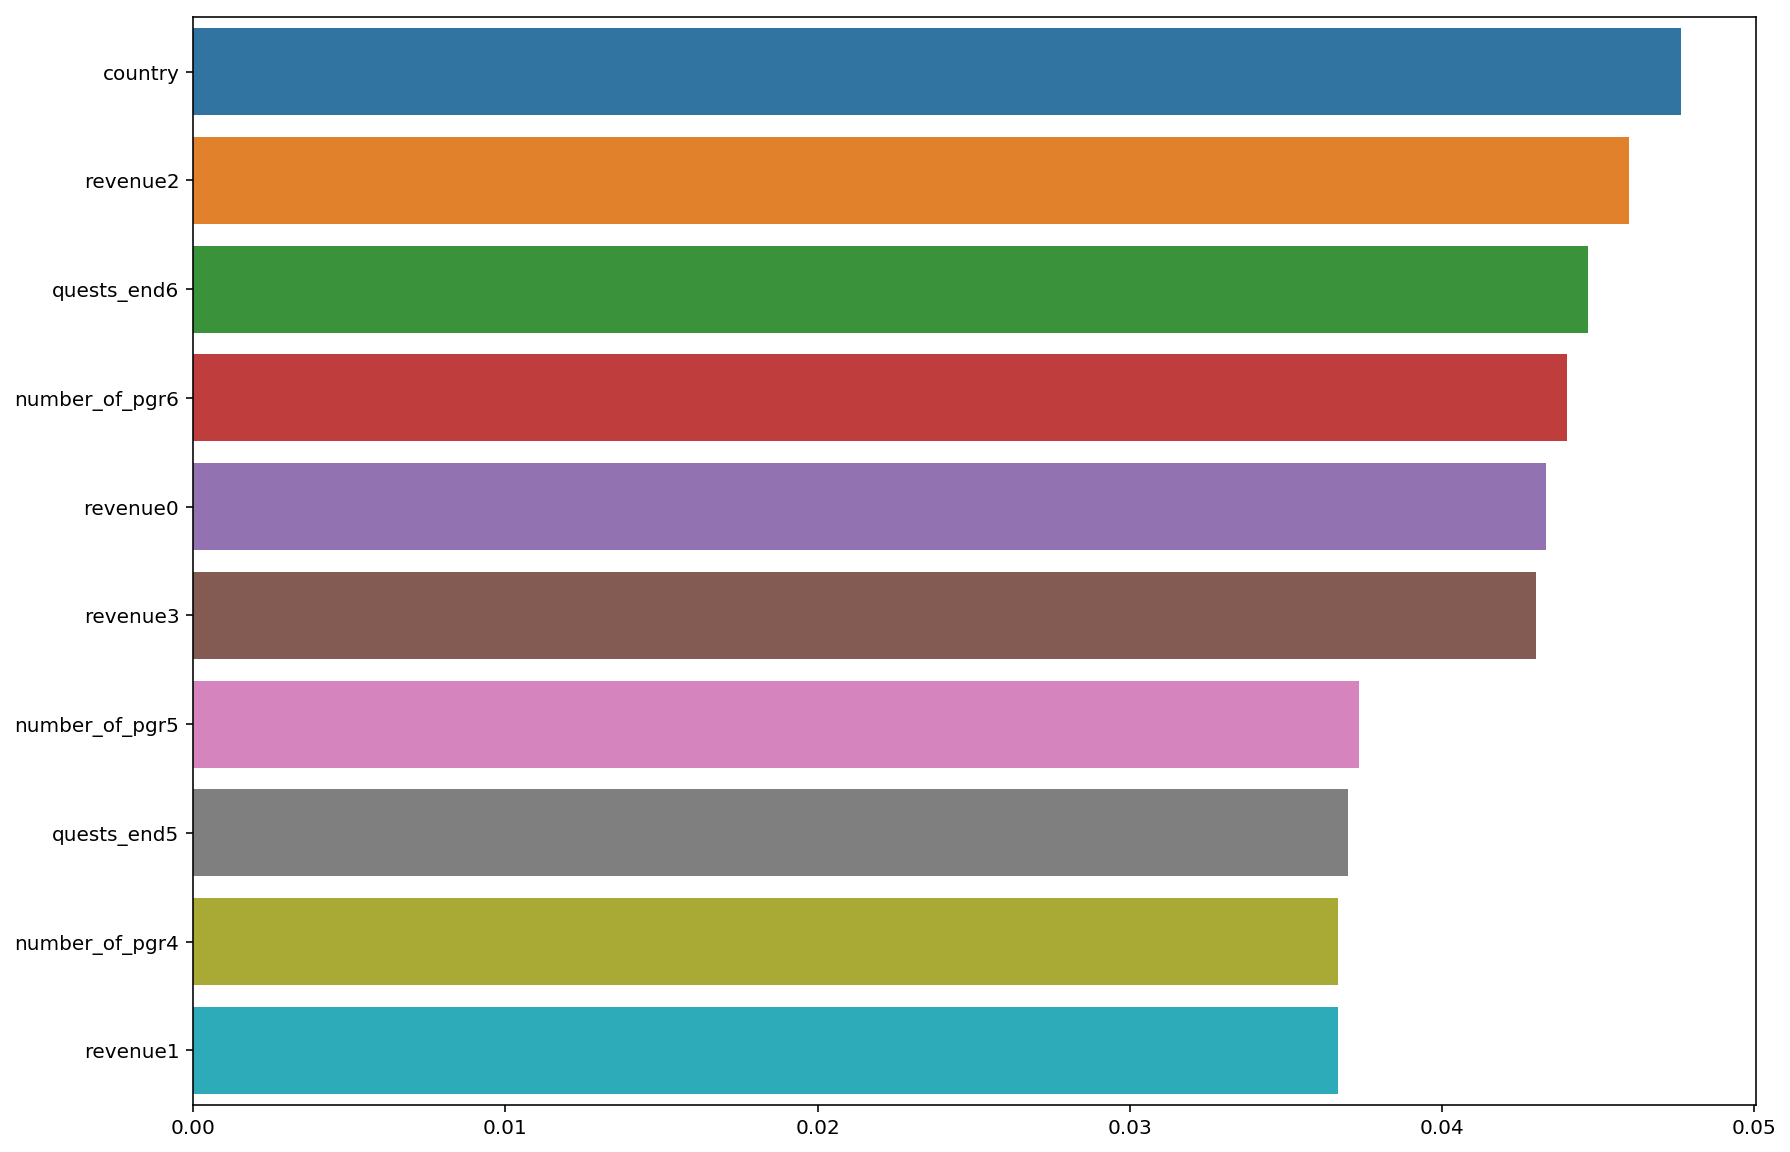

Timestamp: 28 Jul 23:41:41 Time period: 7-30


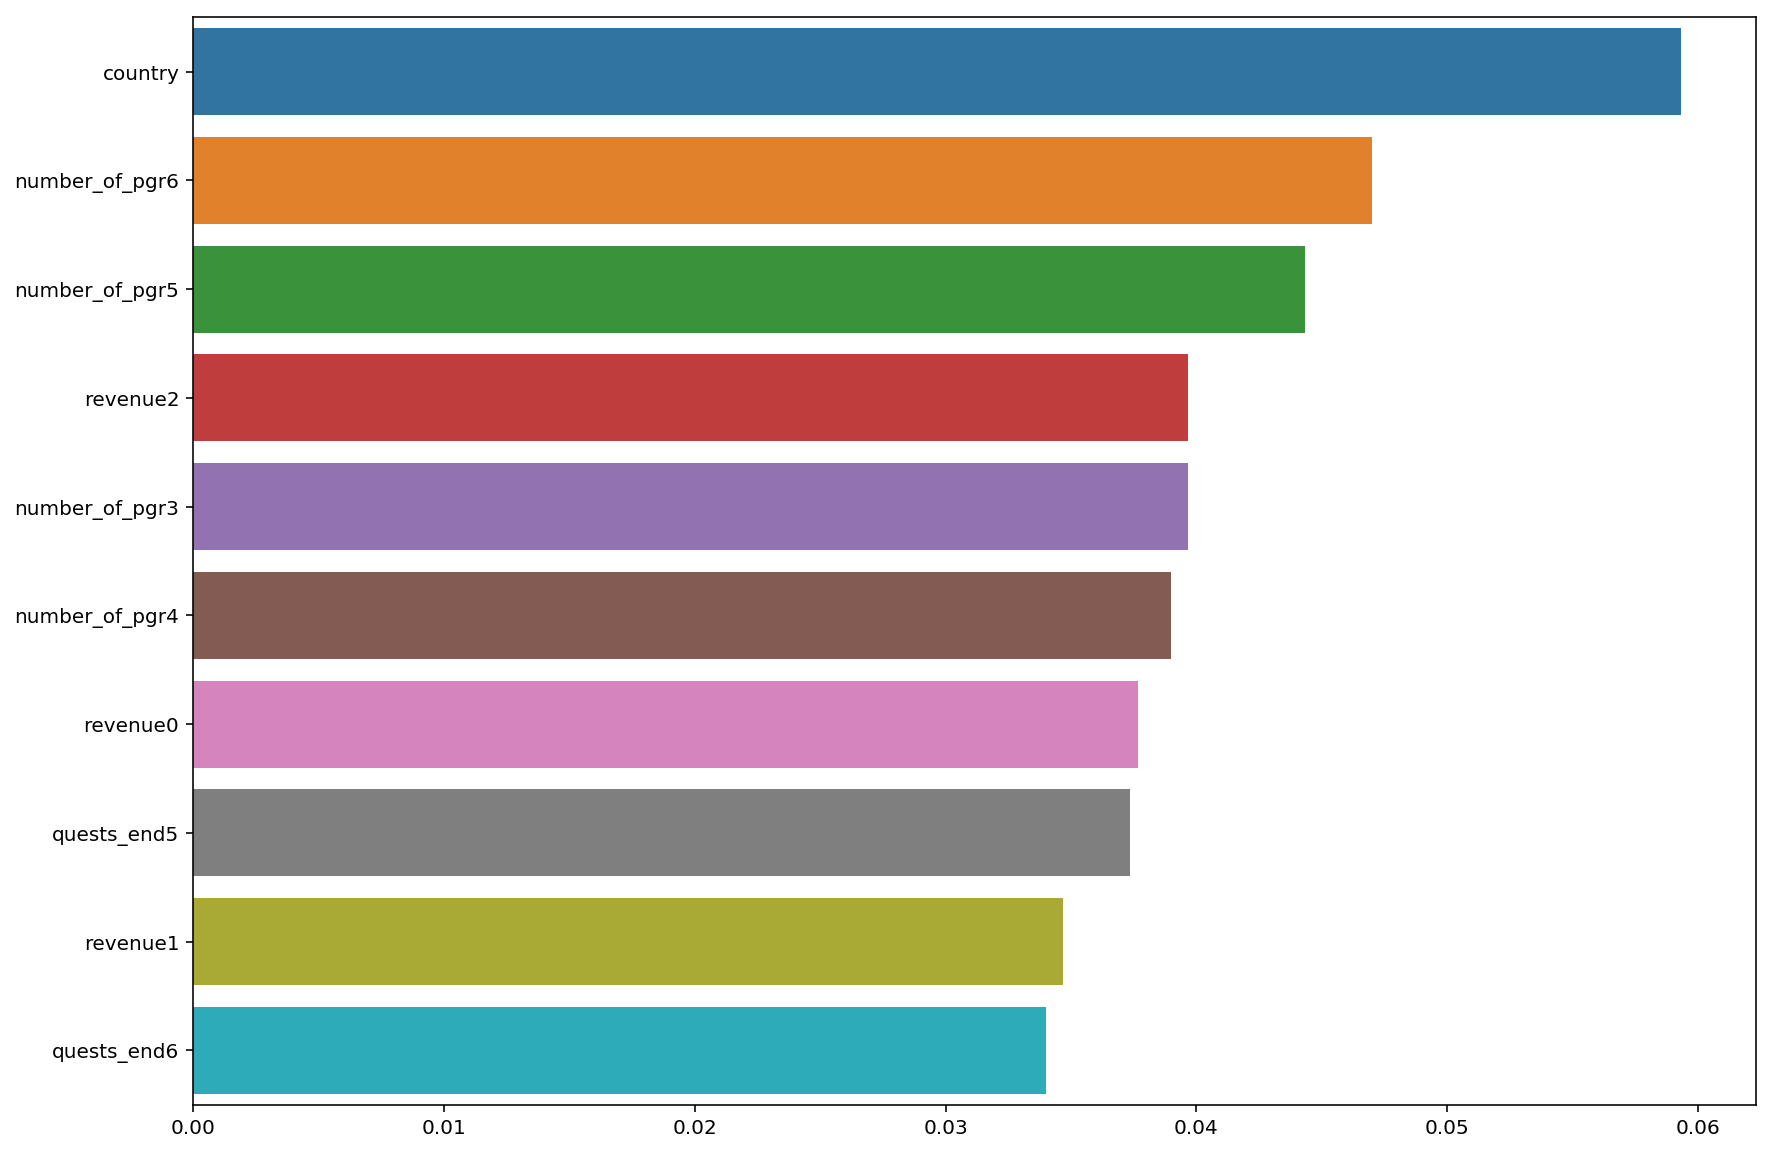

Timestamp: 28 Jul 23:54:00 Time period: 7-60


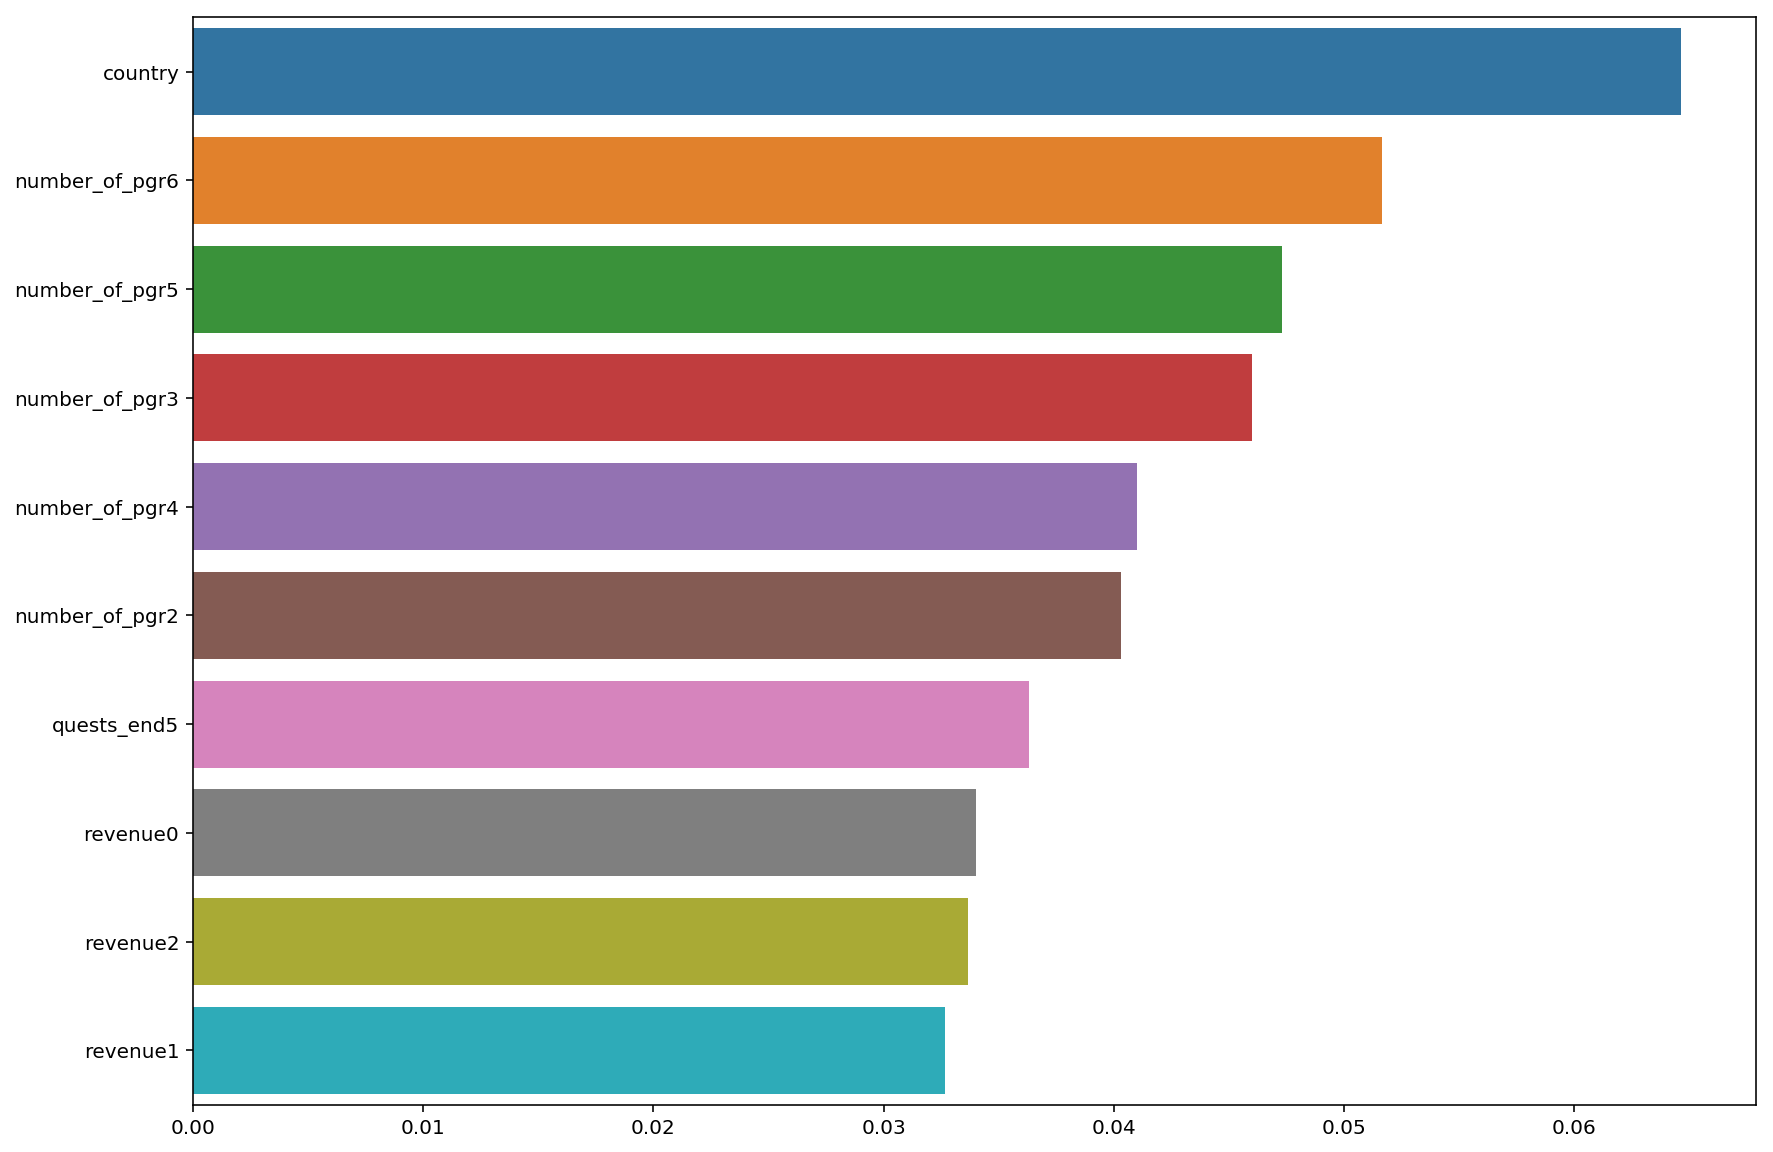

Timestamp: 29 Jul 00:06:27 Time period: 7-100


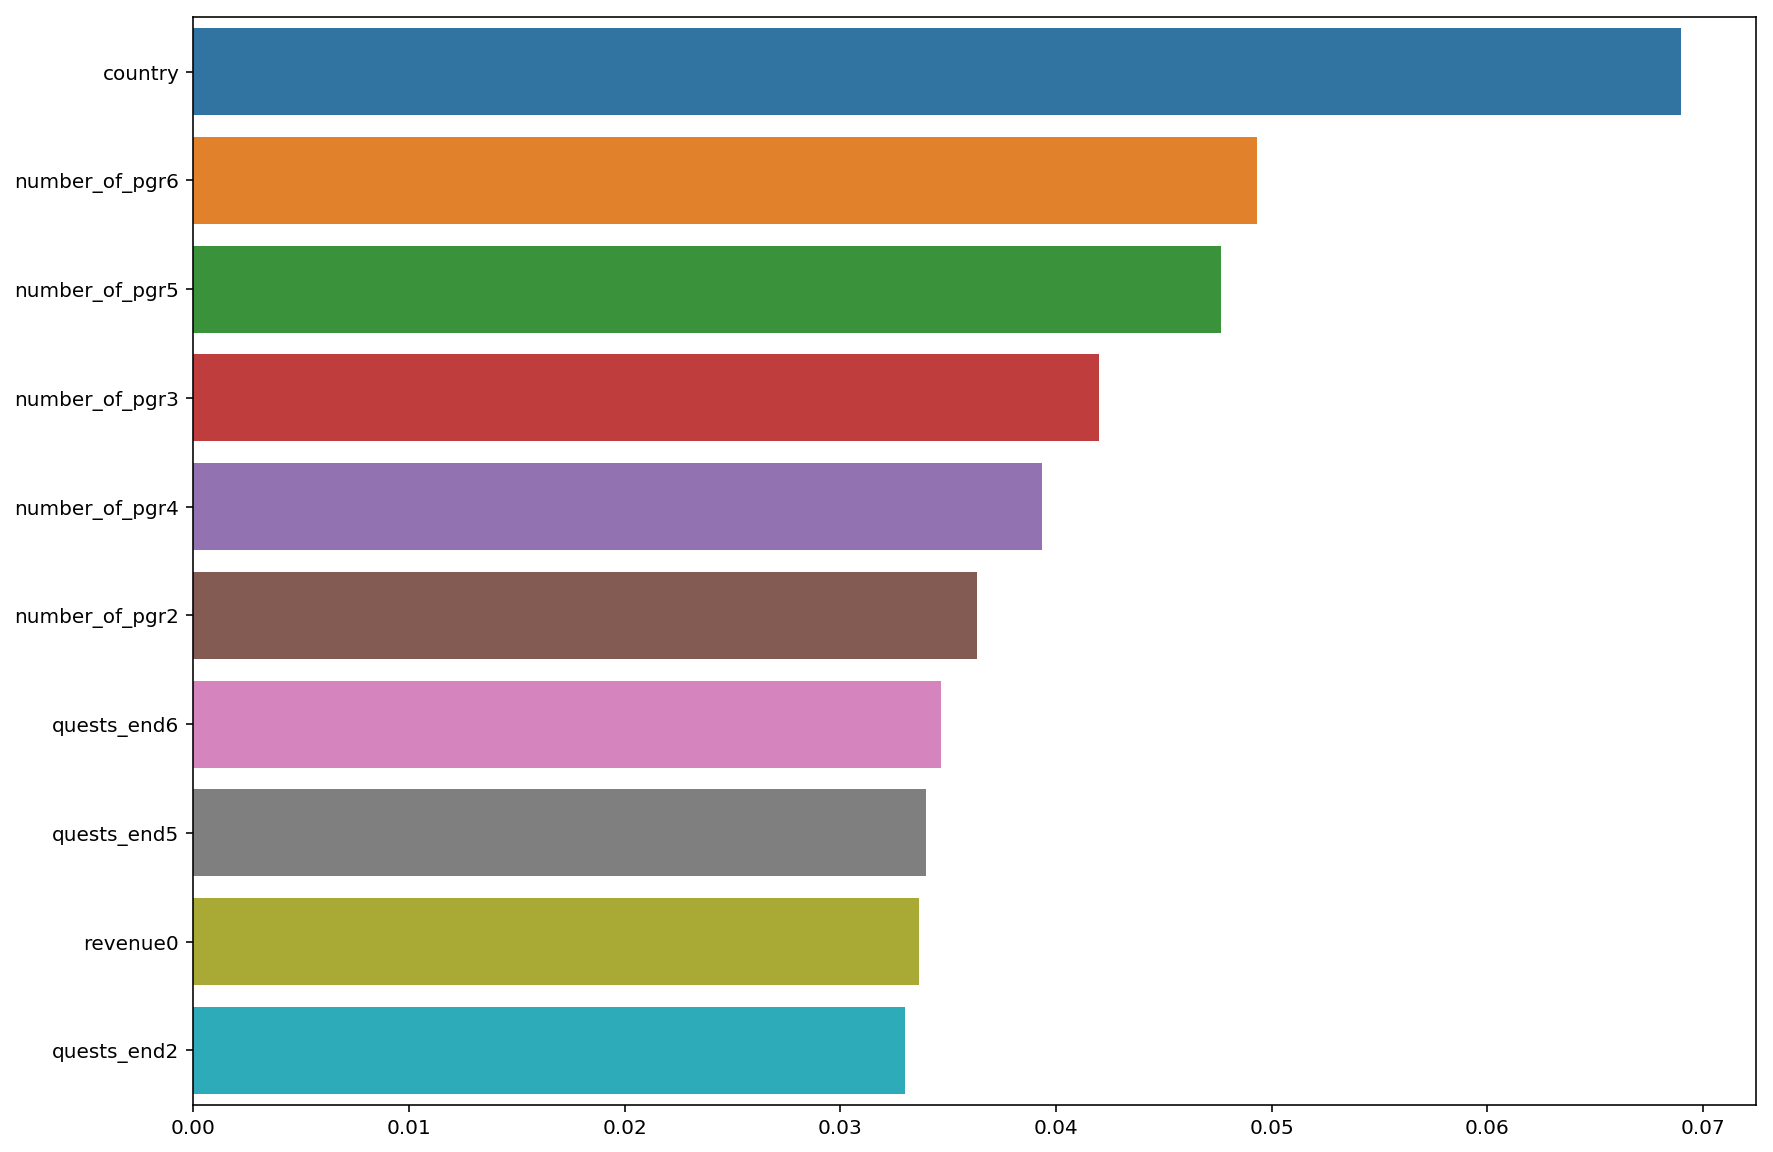

Timestamp: 29 Jul 00:18:50 Time period: 15-15


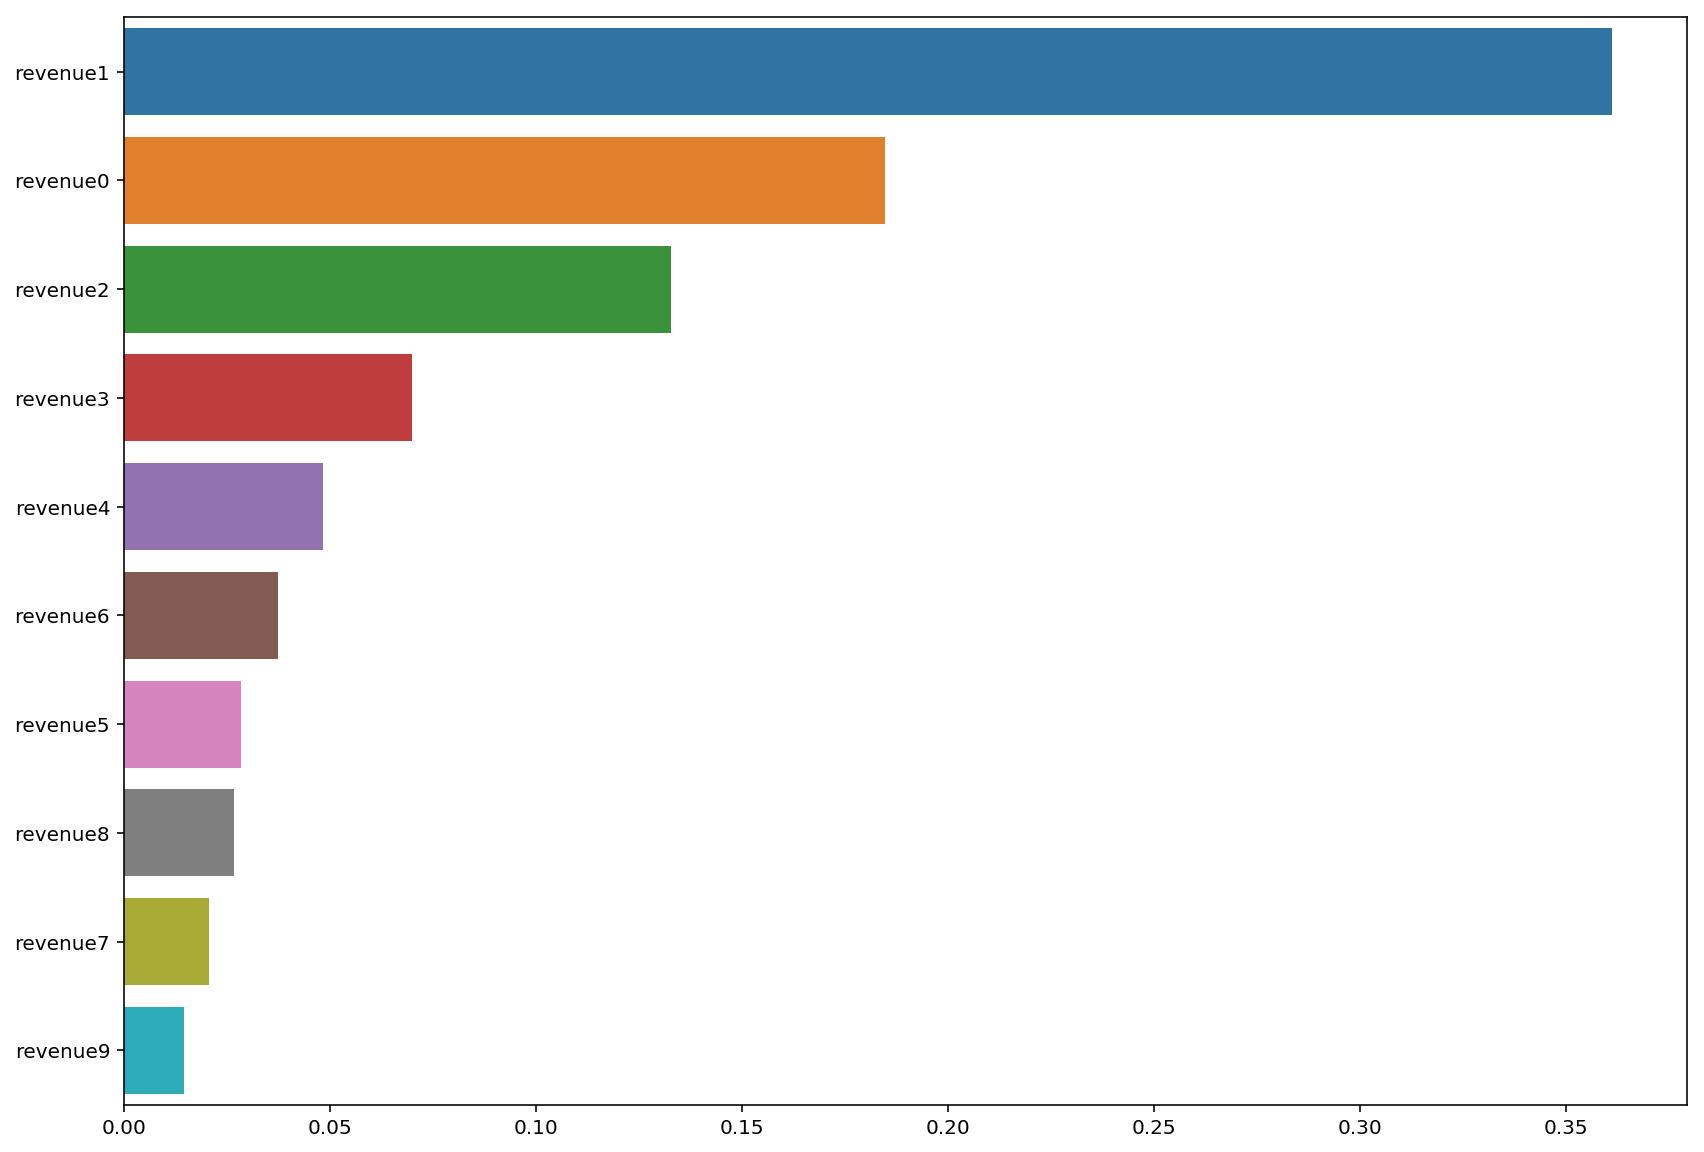

Timestamp: 29 Jul 00:39:09 Time period: 15-30


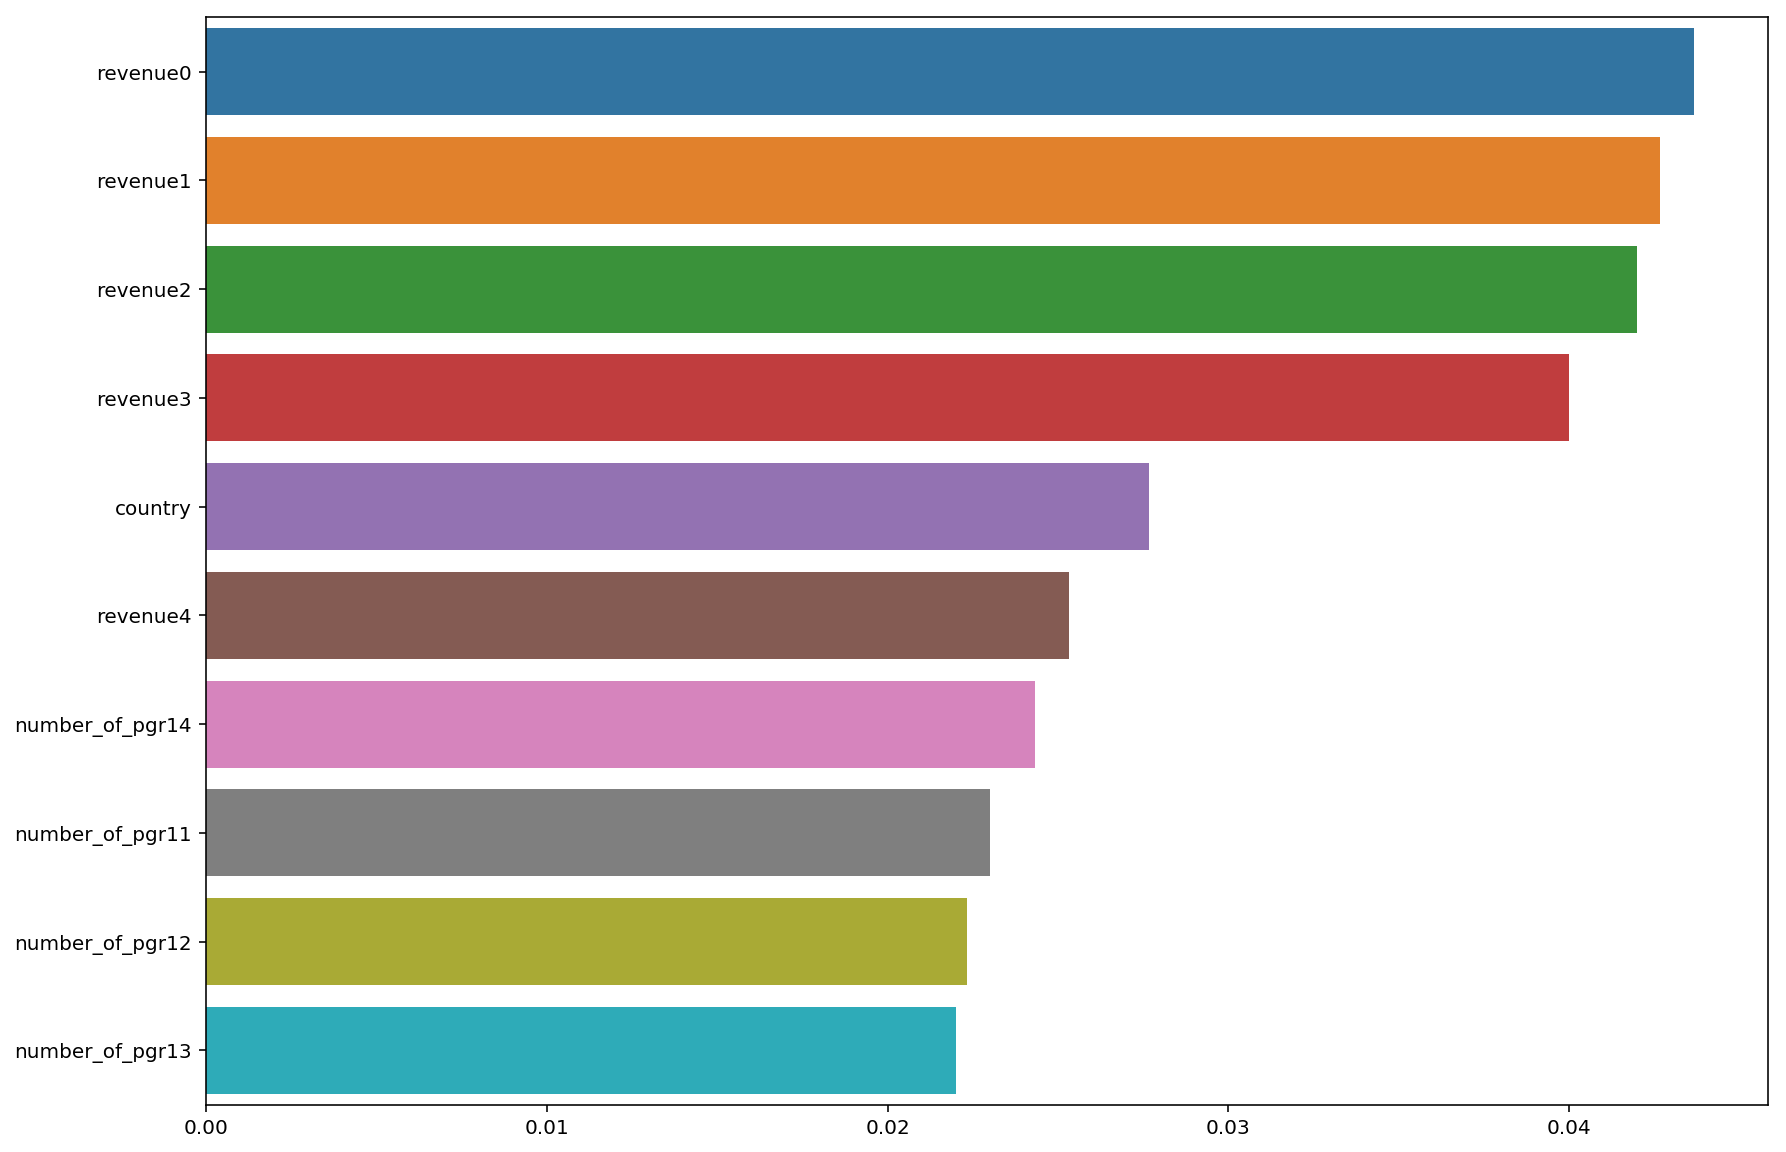

Timestamp: 29 Jul 01:07:06 Time period: 15-60


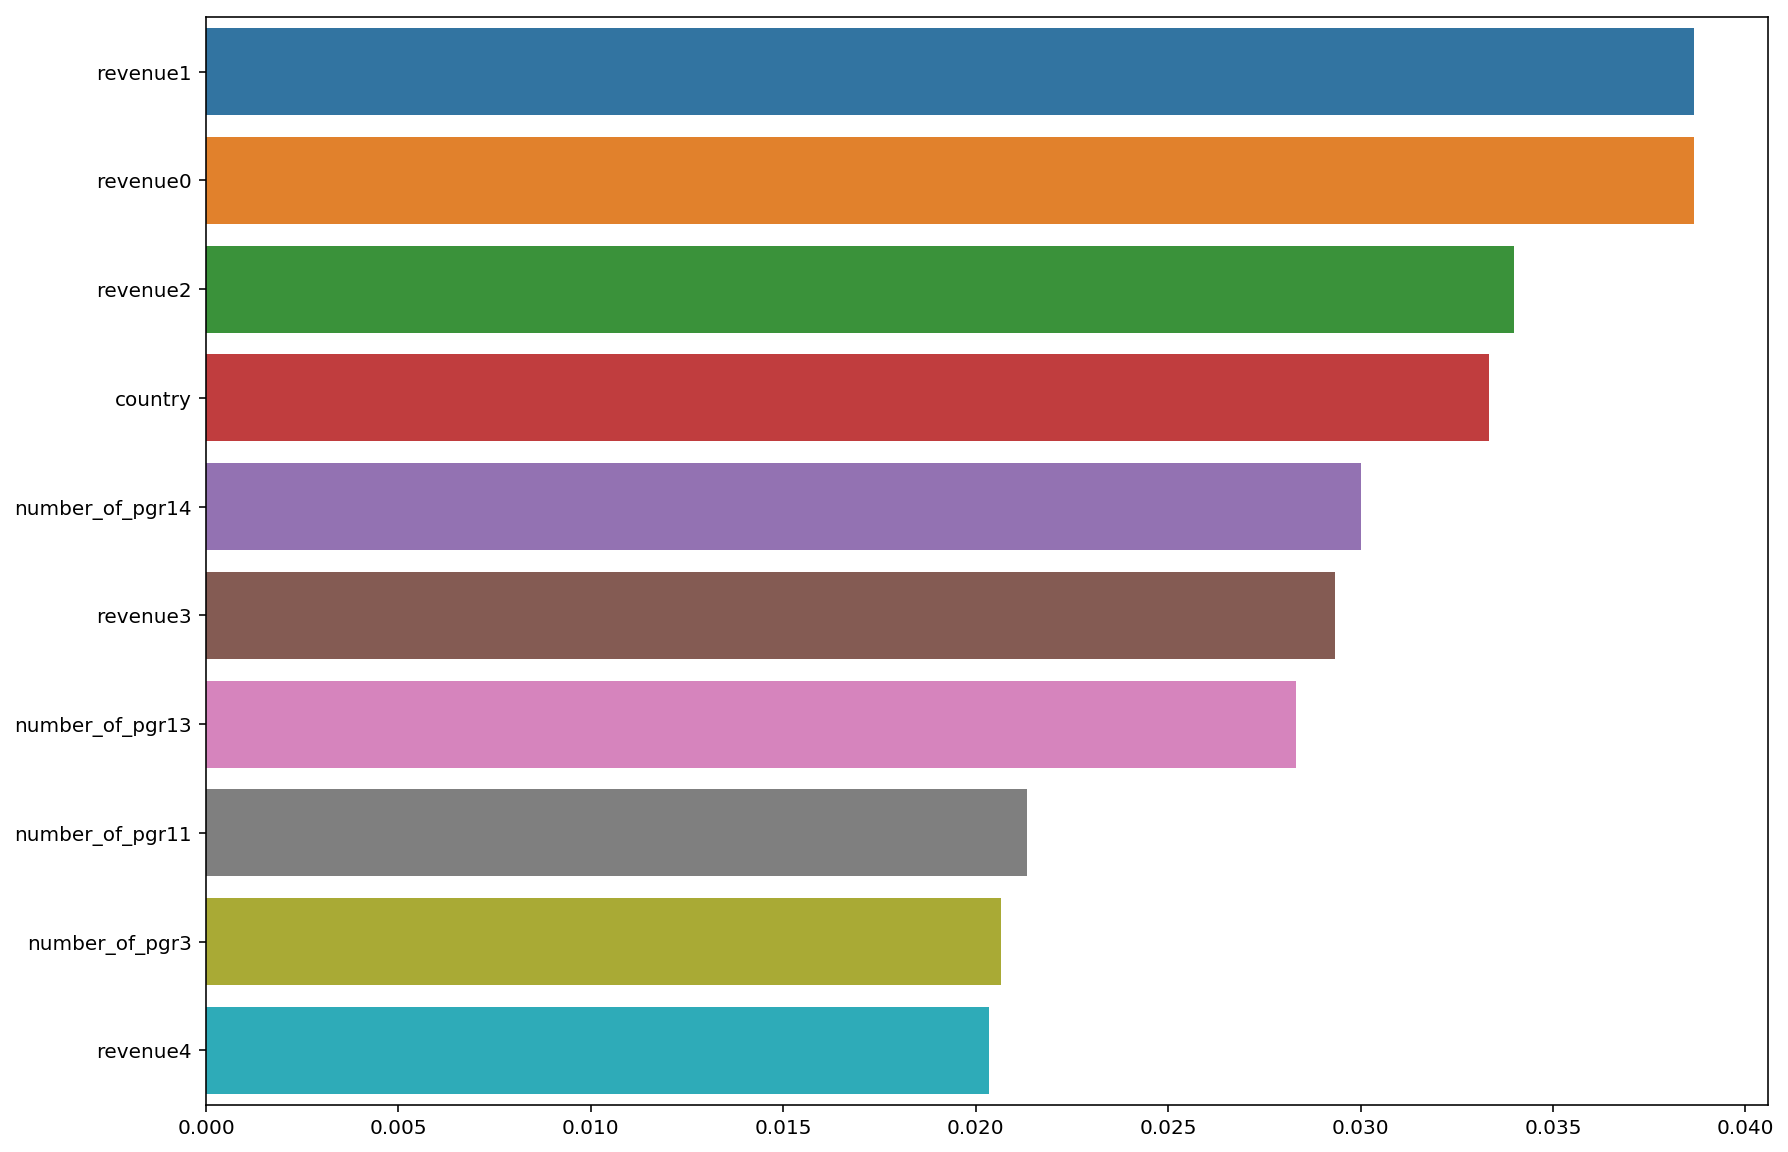

Timestamp: 29 Jul 01:35:02 Time period: 15-100


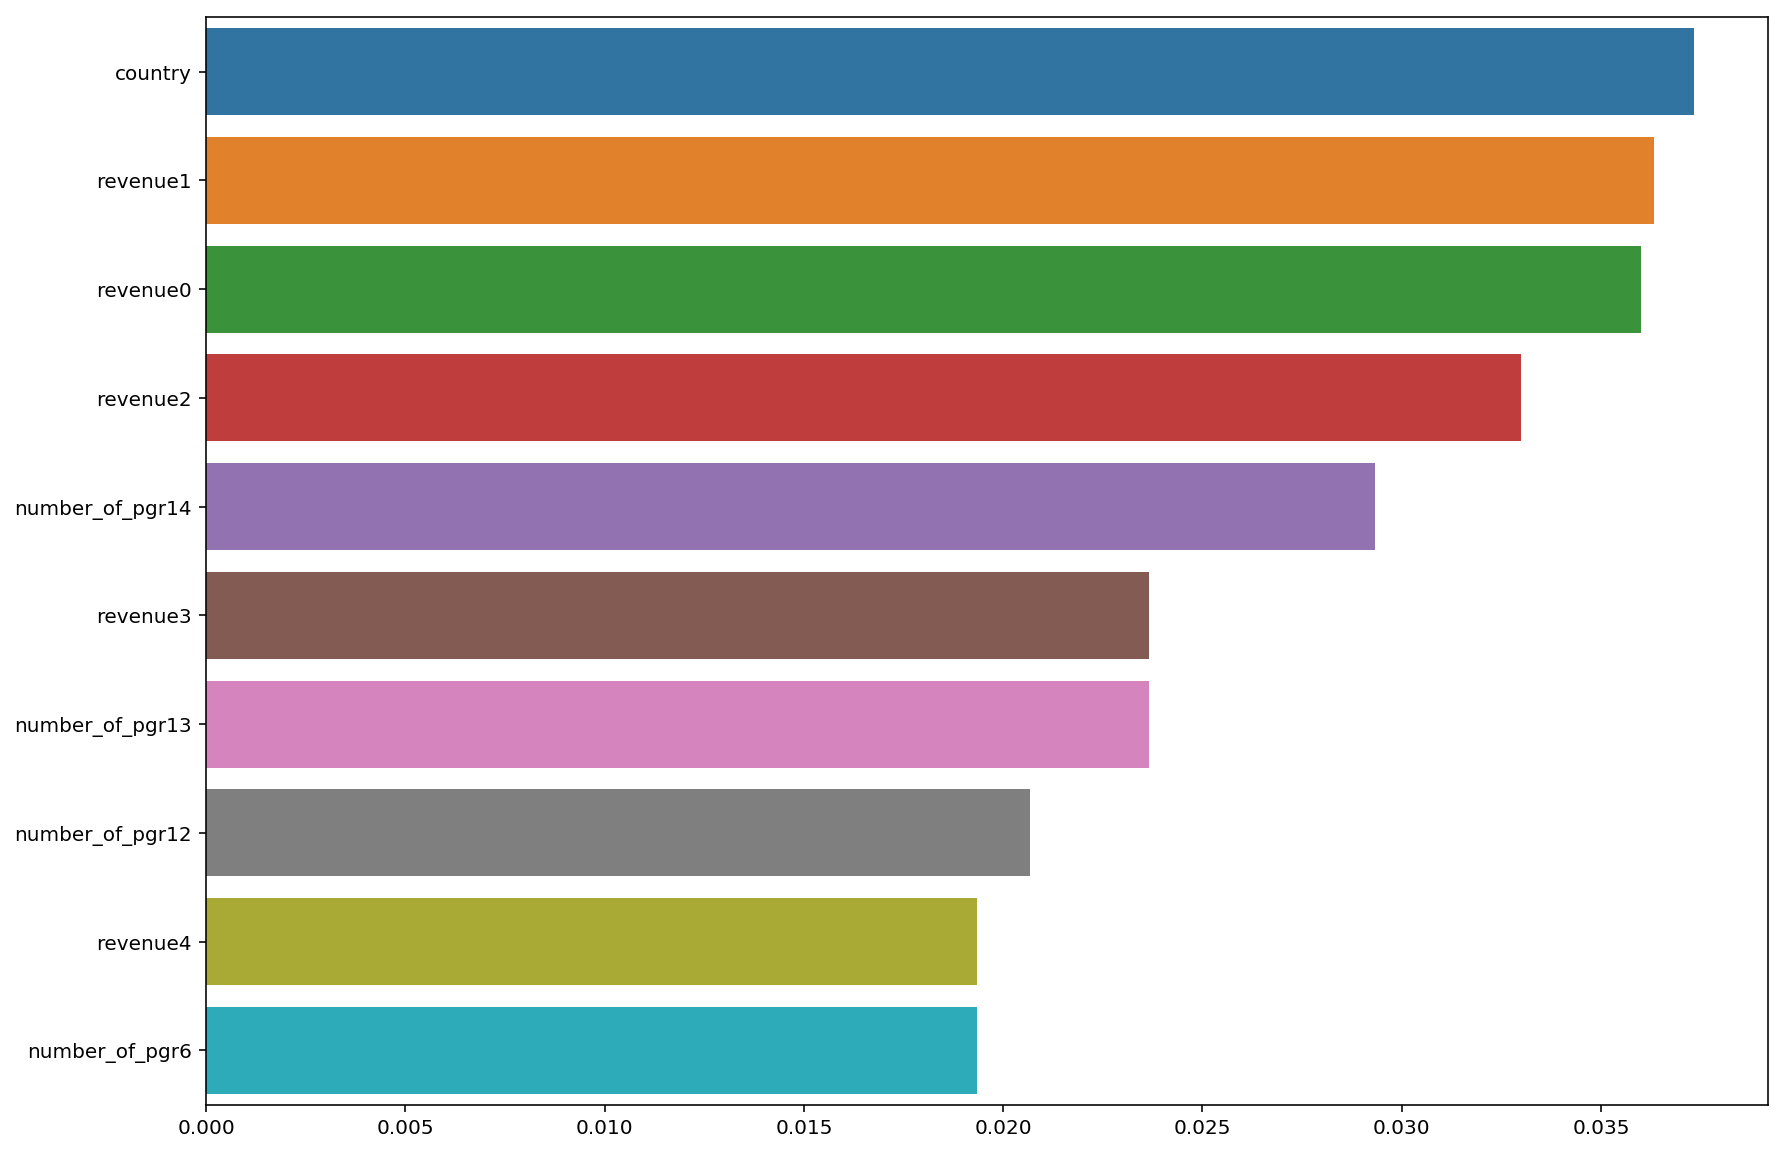

In [5]:
results_list=[get_models_scores(pact,obs,pred) for obs,pred in product([3,7,15],[15,30,60,100])]

In [6]:
pd.concat([item[0] for item in results_list])

,LightGBM,ElasticNet,RandomForestRegressor,ExtraTreesRegressor,GradientBoostingRegressor,RMS of revenues
3-15,75.687130,86.485951,83.285113,82.991126,75.834528,132.316796
3-30,82.809585,92.900504,90.934007,91.818712,82.948161,136.922509
3-60,85.193804,95.069545,94.523769,95.370165,85.311021,138.534926
3-100,85.319743,95.195913,94.707280,96.623604,85.451867,138.637898
7-15,47.990553,77.184530,52.578204,52.433104,52.534312,132.315740
7-30,58.797416,84.250226,64.671098,64.571497,62.875380,136.921411
7-60,62.163296,86.605844,68.956085,69.111934,66.207727,138.533827
7-100,62.393450,86.740964,69.801792,69.901932,66.475295,138.636799
15-15,3.550891,73.703875,4.412846,3.068874,39.010473,132.315607
15-30,34.548365,80.995856,38.668738,37.973240,52.388787,136.921275


In [7]:
pd.concat([item[1] for item in results_list])

,LightGBM,ElasticNet,RandomForestRegressor,ExtraTreesRegressor,GradientBoostingRegressor,Mean of revenues
3-15,10.722638,16.266067,14.628501,13.782627,10.568246,17.826004
3-30,13.148237,18.428320,17.330645,17.232189,13.045966,19.073633
3-60,14.129032,19.342985,19.153392,18.922614,13.967791,19.519251
3-100,14.445213,19.509275,19.366894,19.626980,14.491804,19.547527
7-15,4.250850,13.897376,5.955902,6.004149,6.821689,17.825718
7-30,6.635358,16.065518,9.098704,9.048118,9.302467,19.073328
7-60,7.743445,16.950475,10.588569,10.540369,10.312732,19.518940
7-100,7.976648,17.111420,11.032908,10.964378,10.589769,19.547215
15-15,0.141280,13.150380,0.113949,0.054641,5.468349,17.825684
15-30,2.664132,15.253727,3.432150,3.423337,7.915868,19.073290


In [8]:
pd.concat([item[2] for item in results_list])

,LightGBM,ElasticNet,RandomForestRegressor,ExtraTreesRegressor,GradientBoostingRegressor,True sum
3-15,207751.095601,180411.754615,289009.009228,265860.969486,203304.140672,234262.15625
3-30,226984.414049,186934.345154,323551.764046,298527.151475,216144.298602,250215.12500
3-60,236652.499250,188405.270201,323634.577228,313648.802999,222402.188795,256006.56250
3-100,235280.038141,187165.845806,322880.863407,321834.276003,226991.610310,256006.56250
7-15,225581.812889,185477.138561,251212.232614,247265.876849,218220.694883,234262.15625
7-30,237892.488685,190235.962699,277127.376228,277207.887775,231632.872599,250215.12500
7-60,247739.616003,190930.451627,293290.319977,292998.943683,239122.597332,256006.56250
7-100,250286.694164,189063.467077,299420.752702,289668.143732,241428.403927,256006.56250
15-15,234484.447825,190419.681599,233924.535767,233698.184753,217808.255728,234262.15625
15-30,246953.125391,194727.687317,259746.944678,263666.755682,232240.480018,250215.12500


Можно заметить, что модель LGBMRegresor показывает наилучшее качество по большей части задач и метрик.

Ниже приведены результаты суммарных предсказаний моделями прибыли для пользователей, зарегистрировавшихся в промежутке от 13 до 19 февраля, при обучении на всех данных до этого момента (такие ранние даты были выбраны для того, чтобы по истечении ста дней после него ещё имелись данные о пользовательской активности для оценки моделей, которые делают предсказания для LTV на 100 дней).

In [9]:
week_result_list=[get_week_results(pact,obs,pred) for obs,pred in product([3,7,15],[15,30,60,100])]

Timestamp: 29 Jul 02:03:16 Time period: 3-15
Timestamp: 29 Jul 02:04:58 Time period: 3-30
Timestamp: 29 Jul 02:06:39 Time period: 3-60
Timestamp: 29 Jul 02:08:21 Time period: 3-100
Timestamp: 29 Jul 02:10:04 Time period: 7-15
Timestamp: 29 Jul 02:13:28 Time period: 7-30
Timestamp: 29 Jul 02:16:56 Time period: 7-60
Timestamp: 29 Jul 02:20:26 Time period: 7-100
Timestamp: 29 Jul 02:24:00 Time period: 15-15
Timestamp: 29 Jul 02:30:21 Time period: 15-30
Timestamp: 29 Jul 02:38:23 Time period: 15-60
Timestamp: 29 Jul 02:46:38 Time period: 15-100


In [10]:
pd.concat([item[0] for item in week_result_list])

,LightGBM,ElasticNet,RandomForestRegressor,ExtraTreesRegressor,GradientBoostingRegressor,True sum
3-15,95975.650038,94475.038052,116738.467871,126237.970287,95581.265699,109101.078125
3-30,106642.618994,103398.160466,127767.695154,141266.182563,105108.531309,120058.375000
3-60,112683.327517,109521.934019,145469.903223,150907.398904,111461.798259,127922.203125
3-100,115422.787501,112236.144544,147572.494962,157874.261917,114084.264425,130922.203125
7-15,105954.926975,98485.902158,118155.443903,120651.606885,102525.713583,109101.078125
7-30,116714.472755,108828.559066,134870.889880,138531.237209,112135.930863,120058.375000
7-60,123008.955003,115623.605666,139452.838582,144671.806848,118292.573972,127922.203125
7-100,125521.754348,118717.900083,140013.953644,156176.027856,121382.773552,130922.203125
15-15,109535.602235,99317.696404,108990.812860,109185.318854,104845.846984,109101.078125
15-30,120148.116826,109942.831325,129479.241858,130097.082916,114156.582013,120058.375000


In [11]:
pd.concat([item[1] for item in week_result_list])

,LightGBM,ElasticNet,RandomForestRegressor,ExtraTreesRegressor,GradientBoostingRegressor,True sum
3-15,98213.936725,102038.456811,119375.857858,132870.417905,98314.820004,108122.570312
3-30,108391.422711,111177.681058,136367.901502,148210.724242,108384.323788,118131.078125
3-60,114753.011584,117251.589242,139819.784484,151198.615071,114536.513335,120288.593750
3-100,118484.881094,119931.096117,145450.247009,164916.825673,117566.990528,123705.578125
7-15,107569.505883,106211.718426,116171.867859,125433.885828,106254.635825,108122.570312
7-30,119251.749323,116886.003738,132385.486865,147769.970868,116595.255595,118131.078125
7-60,124732.752877,123724.000600,138036.564061,152477.119399,123353.969972,120288.593750
7-100,127443.452250,126840.395566,139520.365839,153339.031066,126270.397343,123705.578125
15-15,108067.475366,104445.372542,108660.416870,107852.279828,105349.137461,108122.570312
15-30,119099.809851,115583.373450,128220.657861,130627.077887,114759.959313,118131.078125


In [12]:
pd.concat([item[2] for item in week_result_list])

,LightGBM,ElasticNet,RandomForestRegressor,ExtraTreesRegressor,GradientBoostingRegressor,True sum
3-15,128935.303920,124987.748125,150229.189914,167279.437179,128517.494746,137331.140625
3-30,140874.417189,136157.540849,169211.993063,186549.080448,140038.497610,154339.656250
3-60,148235.149907,143450.125016,179261.215179,196433.175886,147355.082931,161339.656250
3-100,151002.834081,146656.321770,182267.089727,205382.686854,150557.961262,164339.656250
7-15,136708.081311,132338.222403,151205.795926,154960.830467,136662.819111,137331.140625
7-30,149925.881782,145316.829197,169320.989576,177323.535496,148490.342381,154339.656250
7-60,157021.327087,153513.433517,181849.029202,187683.442322,156300.628302,161339.656250
7-100,160323.515980,157302.682917,180420.999987,194973.127525,160082.430059,164339.656250
15-15,137172.064069,128007.921407,137208.923859,136998.233826,135592.734043,137331.140625
15-30,150694.796106,141422.401842,156384.355811,167021.731866,147265.853429,154339.656250


In [13]:
pd.concat([item[3] for item in week_result_list])

,LightGBM,ElasticNet,RandomForestRegressor,ExtraTreesRegressor,GradientBoostingRegressor,True sum
3-15,137847.559832,140377.141769,157273.337742,179969.884483,138384.851754,154152.281250
3-30,152007.630468,152273.364516,176972.572170,195826.661415,151061.630328,167747.984375
3-60,159513.058220,160009.737596,193847.966775,204880.140379,159287.695013,177879.812500
3-100,163265.290702,163433.502768,195756.623975,215127.031769,162872.705973,185981.781250
7-15,147620.925488,150586.458934,161551.261755,164617.789777,148704.301523,154152.281250
7-30,163013.201244,164789.289776,177747.761798,191474.795469,161643.837829,167747.984375
7-60,170161.095463,173625.298410,188506.590501,189510.598466,170000.689193,177879.812500
7-100,174426.161199,177720.061722,200907.508427,206001.160957,173589.587833,185981.781250
15-15,154312.925260,150291.689486,154395.022839,154125.823840,154895.055418,154152.281250
15-30,167180.585454,164443.603113,177643.066852,183737.452820,166173.022669,167747.984375


In [14]:
pd.concat([item[4] for item in week_result_list])

,LightGBM,ElasticNet,RandomForestRegressor,ExtraTreesRegressor,GradientBoostingRegressor,True sum
3-15,151532.169978,149349.344115,180897.886771,194046.228687,151954.229522,167802.906250
3-30,166277.236118,161761.488143,198416.557072,202622.250030,164520.757945,183624.218750
3-60,173408.692974,169706.440527,207140.004986,217479.955794,172864.312754,195215.734375
3-100,176498.943311,173222.855630,213103.040373,226177.043385,175976.702918,197215.734375
7-15,156111.263371,149103.508764,167078.791687,175545.632648,154858.444955,167802.906250
7-30,169551.751704,163325.207813,193221.062642,194000.334680,166742.038822,183624.218750
7-60,176935.841981,171972.935666,201173.936724,202340.525871,174426.668177,195215.734375
7-100,180773.511990,176072.784262,207065.619772,219088.124382,177970.848738,197215.734375
15-15,167649.379458,150113.896007,167176.568756,167770.611700,159980.546059,167802.906250
15-30,180298.460303,164803.485793,187813.742725,191681.434698,170303.258758,183624.218750


In [15]:
pd.concat([item[5] for item in week_result_list])

,LightGBM,ElasticNet,RandomForestRegressor,ExtraTreesRegressor,GradientBoostingRegressor,True sum
3-15,176347.205962,169596.510401,208457.425050,230303.587674,174841.175618,186675.56250
3-30,192507.581368,183098.915545,225180.624686,237589.830056,189096.223607,200003.12500
3-60,200029.839122,191654.763978,232741.621516,248007.963257,197907.740051,215237.21875
3-100,203395.392218,195403.218257,242929.391887,255915.759075,202072.365584,219079.71875
7-15,181184.519004,169760.982266,196005.725745,198131.345721,179634.530342,186675.56250
7-30,197154.192314,185200.423879,220114.348700,226235.649394,192784.437223,200003.12500
7-60,204274.430337,194375.603374,226095.336215,233822.935061,201080.895043,215237.21875
7-100,208934.248356,198715.341146,234006.948706,244558.450174,204079.491687,219079.71875
15-15,186108.496002,173063.640557,186083.406787,186026.389813,181302.515094,186675.56250
15-30,203043.890443,191037.817972,219605.575684,222500.126782,195387.534812,200003.12500


In [16]:
pd.concat([item[6] for item in week_result_list])

,LightGBM,ElasticNet,RandomForestRegressor,ExtraTreesRegressor,GradientBoostingRegressor,True sum
3-15,210742.526510,199484.481391,248880.743624,264472.361944,209086.044980,220202.296875
3-30,228450.917753,213391.991854,267931.041610,277488.615226,223667.363197,232793.812500
3-60,235842.986375,222171.866696,287792.223452,291845.110291,232945.869264,243568.218750
3-100,240076.370223,226002.249377,293061.346238,313034.892630,236141.807148,248636.312500
7-15,220505.253851,206168.761187,236815.292596,240525.714612,218429.024683,220202.296875
7-30,235629.044077,222975.072375,256677.726624,275173.512990,232039.779219,232793.812500
7-60,244925.948533,232919.693919,276941.987278,284448.391693,240167.758824,243568.218750
7-100,247853.289341,237511.575815,281170.045268,301397.430996,243977.246295,248636.312500
15-15,220052.427110,209340.597579,220301.483679,219817.159650,222636.247723,220202.296875
15-30,235188.998192,228053.797162,250211.545624,254691.524683,235951.601034,232793.812500


LightGBM и в этом случае показывает лучшие результаты в сравнении с иными алгоритмами, поэтому в дальнейшем было принято решение исследовать различные способы формирования признаков и влияние удаления даты предсказания от последней даты, зафиксированной в обучающей выборке, на этой модели.

In [17]:
def eval_model(threshold=1000):
    train,test=split_data(pact,3,30,threshold=threshold)
    regr=LGBMRegressor(n_estimators=100,seed=100)
    x_train,y_train=train.drop("revenue",axis=1),train.revenue
    x_test,y_test=test.drop("revenue",axis=1),test.revenue
    regr.fit(x_train,y_train)
    return(np.sqrt(mean_squared_error(y_test,regr.predict(x_test))),mean_absolute_error(y_test,regr.predict(x_test)))

In [18]:
df=pd.DataFrame([eval_model(threshold=thresh) for thresh in range(1000,51000,1000)],
                index=range(1000,51000,1000),columns=["RMSE","MAE"])

Ниже изображена зависимость RMSE и MAE предсказания прибыли на 30 дней по наблюдениям за 3 дня от порога, при превышении которого показатели прибыли «обрезались».

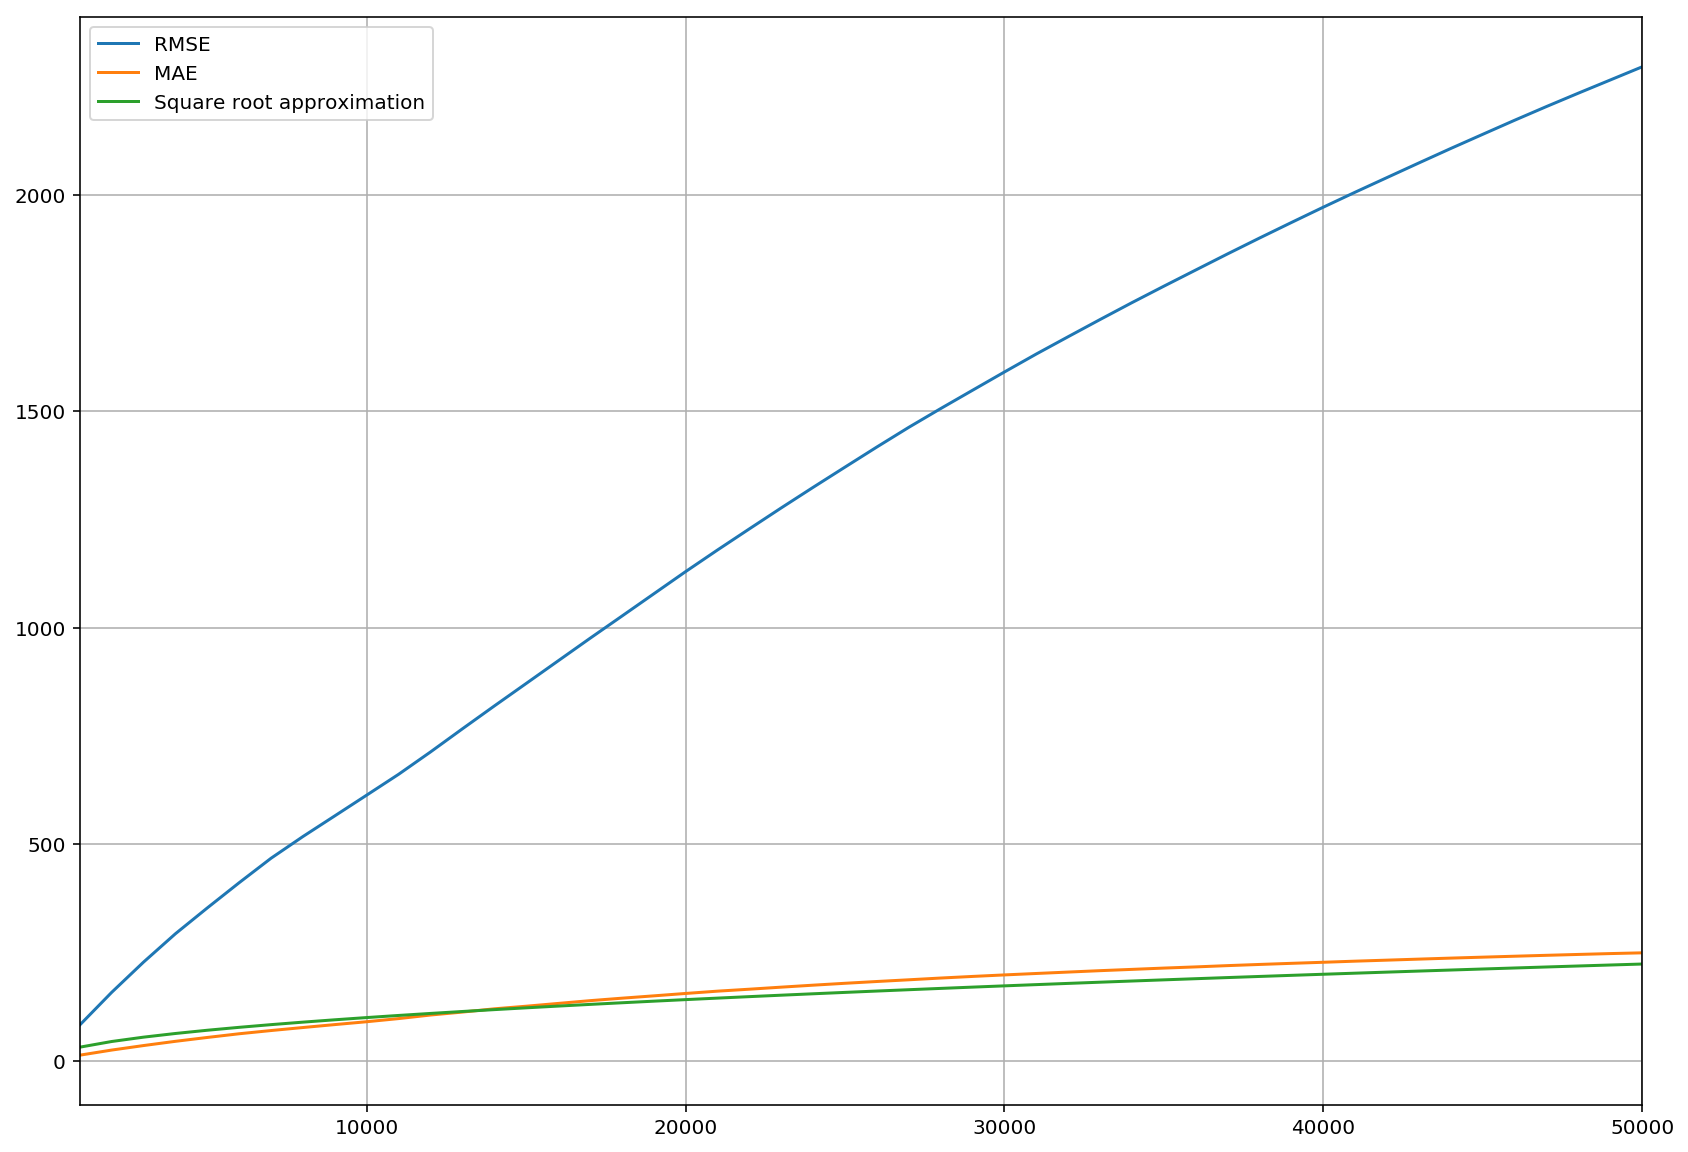

In [70]:
df.plot()
x=np.linspace(1000,50000)
y=np.sqrt(x)
plt.plot(x,y,label="Square root approximation")
plt.legend()
plt.grid()

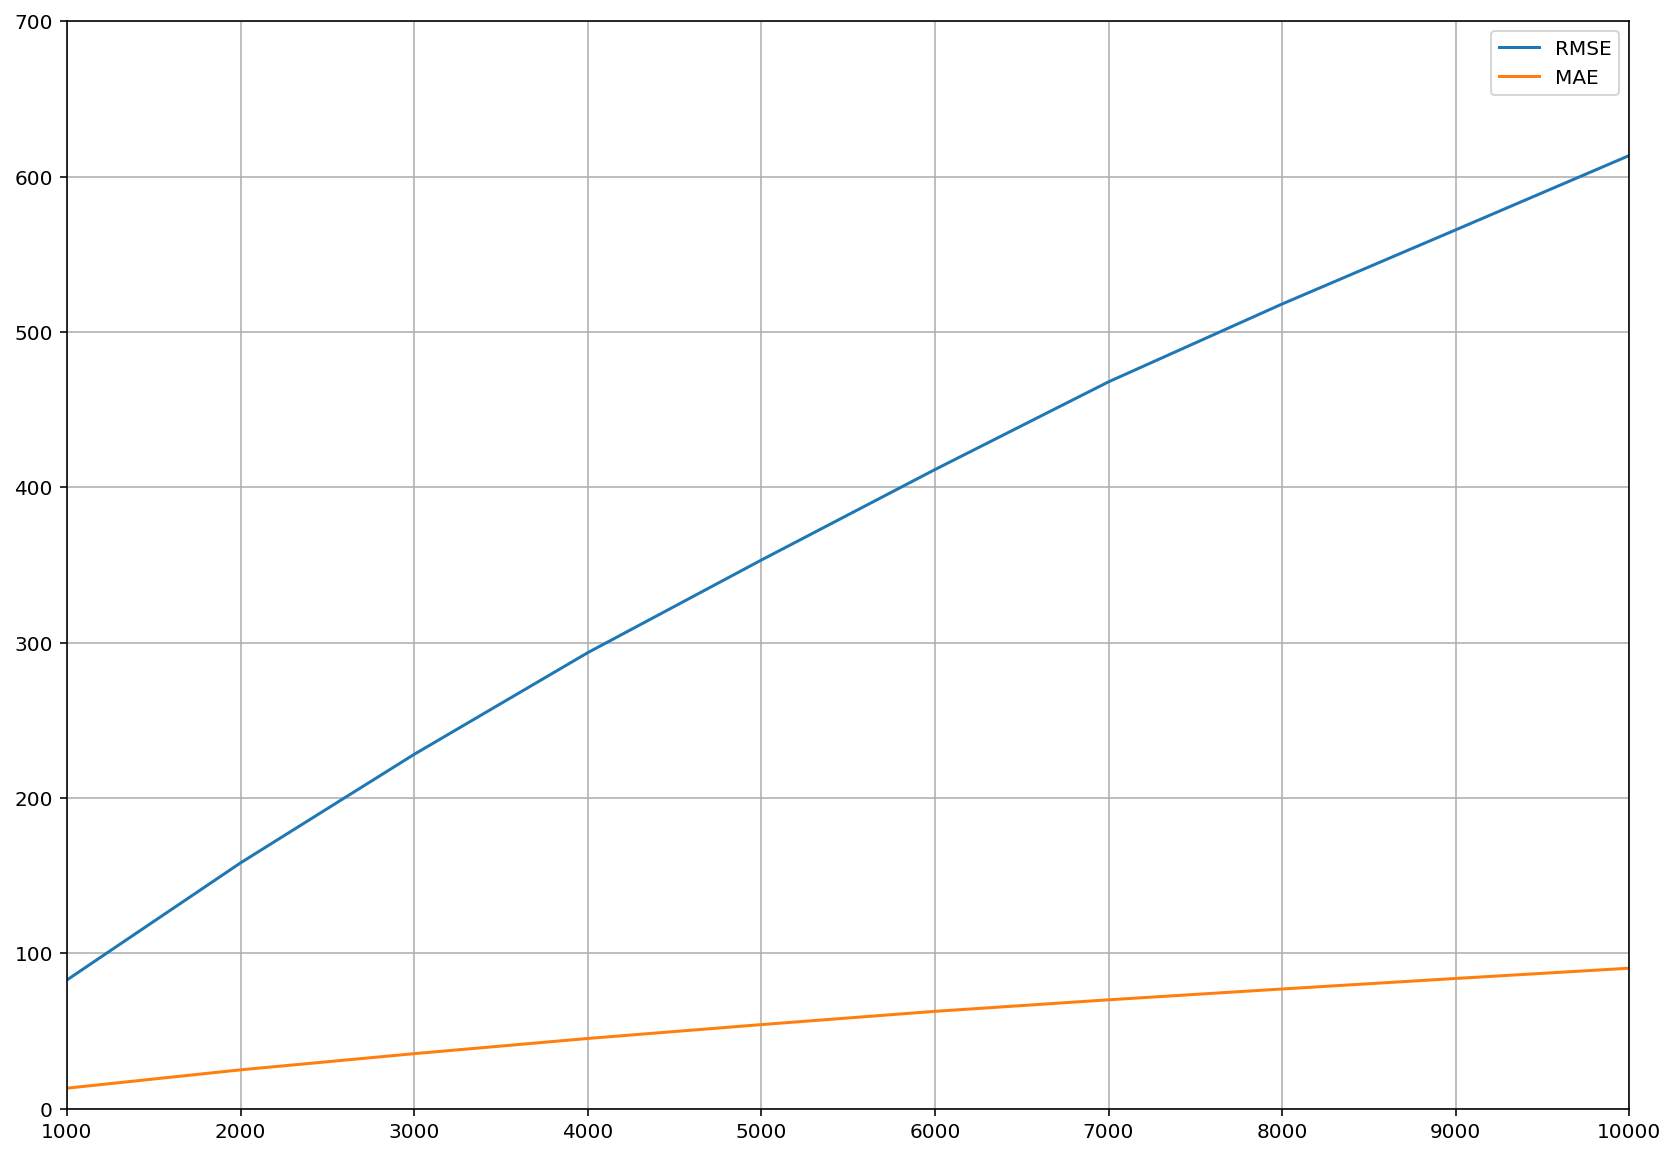

In [73]:
df.plot(xlim=(1000,10000),ylim=(0,700))
plt.grid()

MSE до добавления признаков на предсказании LTV за 60 дней по 7: 

In [20]:
train,test=split_data(pact,7,60)
regr=LGBMRegressor(n_estimators=100,seed=100)
regr.fit(train.drop("revenue",axis=1),train.revenue)
mean_squared_error(test.revenue,regr.predict(test.drop("revenue",axis=1)))

3864.2754193908727

MSE после добавления признаков. Можно заметить, что прирост получился незначительный в масштабах величины ошибки

In [21]:
train,test=split_data(pact,7,60,extra_features=True)
regr=LGBMRegressor(n_estimators=100,seed=100)
regr.fit(train.drop("revenue",axis=1),train.revenue)
mean_squared_error(test.revenue,regr.predict(test.drop("revenue",axis=1)))

3863.046896450634

Также было проведено исследование зависимости величины ошибки в зависимости от удаления дня предсказания от последнего дня в обучающей выборке и числа наблюдаемых дней перед совершением предсказания. Для этого выборка разбивалась на обучающую и тестовую по месяцам (январь и февраль — в первую часть, март и далее — во вторую), а затем для каждого дня тестовой выборки отдельно считалась RMSE для всех пользователей, пришедших в этот день.

In [75]:
dfs=[]

for days_pred in [15,30,60,100]:
    dfs_samepred=[]
    for days_obs in [3,7,15]:
        print("{0}-{1}".format(days_obs,days_pred))
        train,test=split_data(pact.copy(),days_obs,days_pred,earlier_split=True)
        regr=LGBMRegressor(n_estimators=100,seed=100)
        x_train,y_train=train.drop("revenue",axis=1),train.revenue
        regr.fit(x_train,y_train)
        losses=[]
        days=[]
        for name,group in test.groupby(["regmonth","regday"]):
            x_test,y_test=group.drop("revenue",axis=1),group.revenue
            losses.append(np.sqrt(mean_squared_error(y_test,regr.predict(x_test))))
            days.append(name)
        dfs_samepred.append(pd.DataFrame(losses,index=days,columns=[days_obs]))
    dfs.append(pd.concat(dfs_samepred,axis=1))

3-15
7-15
15-15
3-30
7-30
15-30
3-60
7-60
15-60
3-100
7-100
15-100


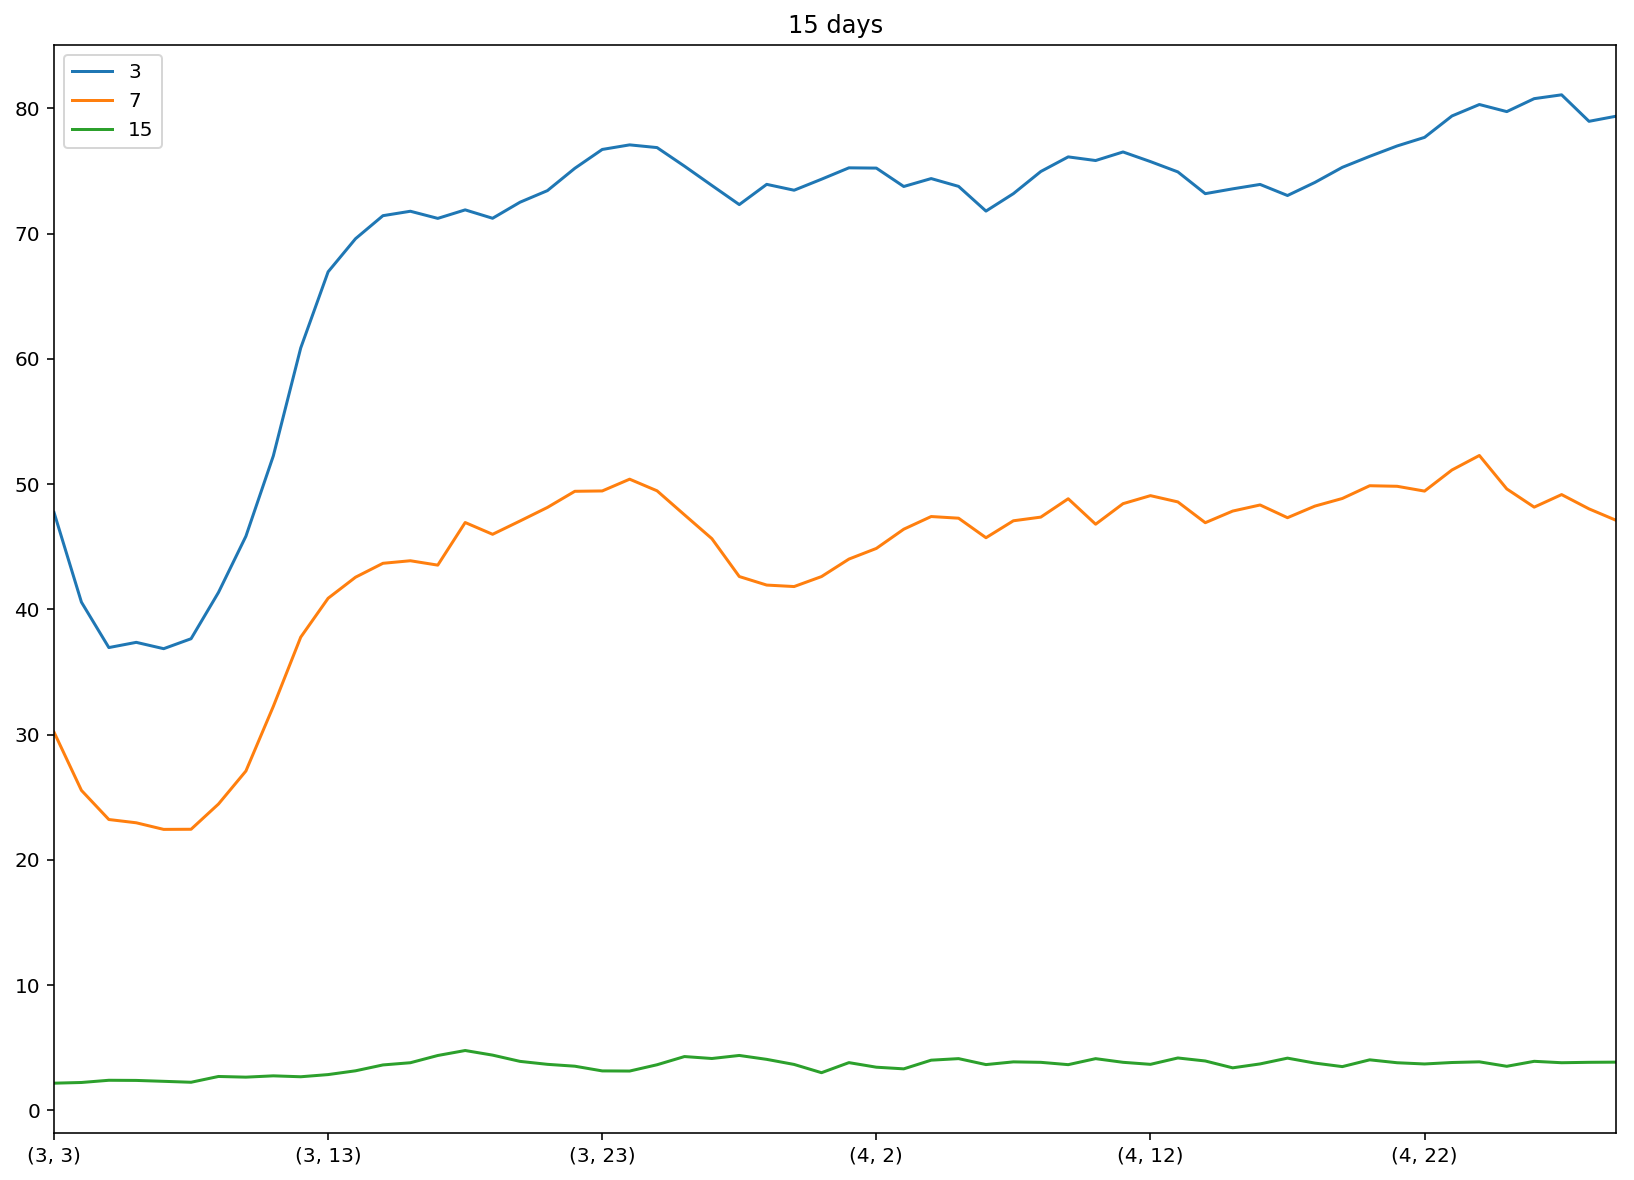

In [90]:
dfs[0].rolling(5,center=True).mean().dropna().plot()
ax=plt.gca()
ax.set_title("15 days")

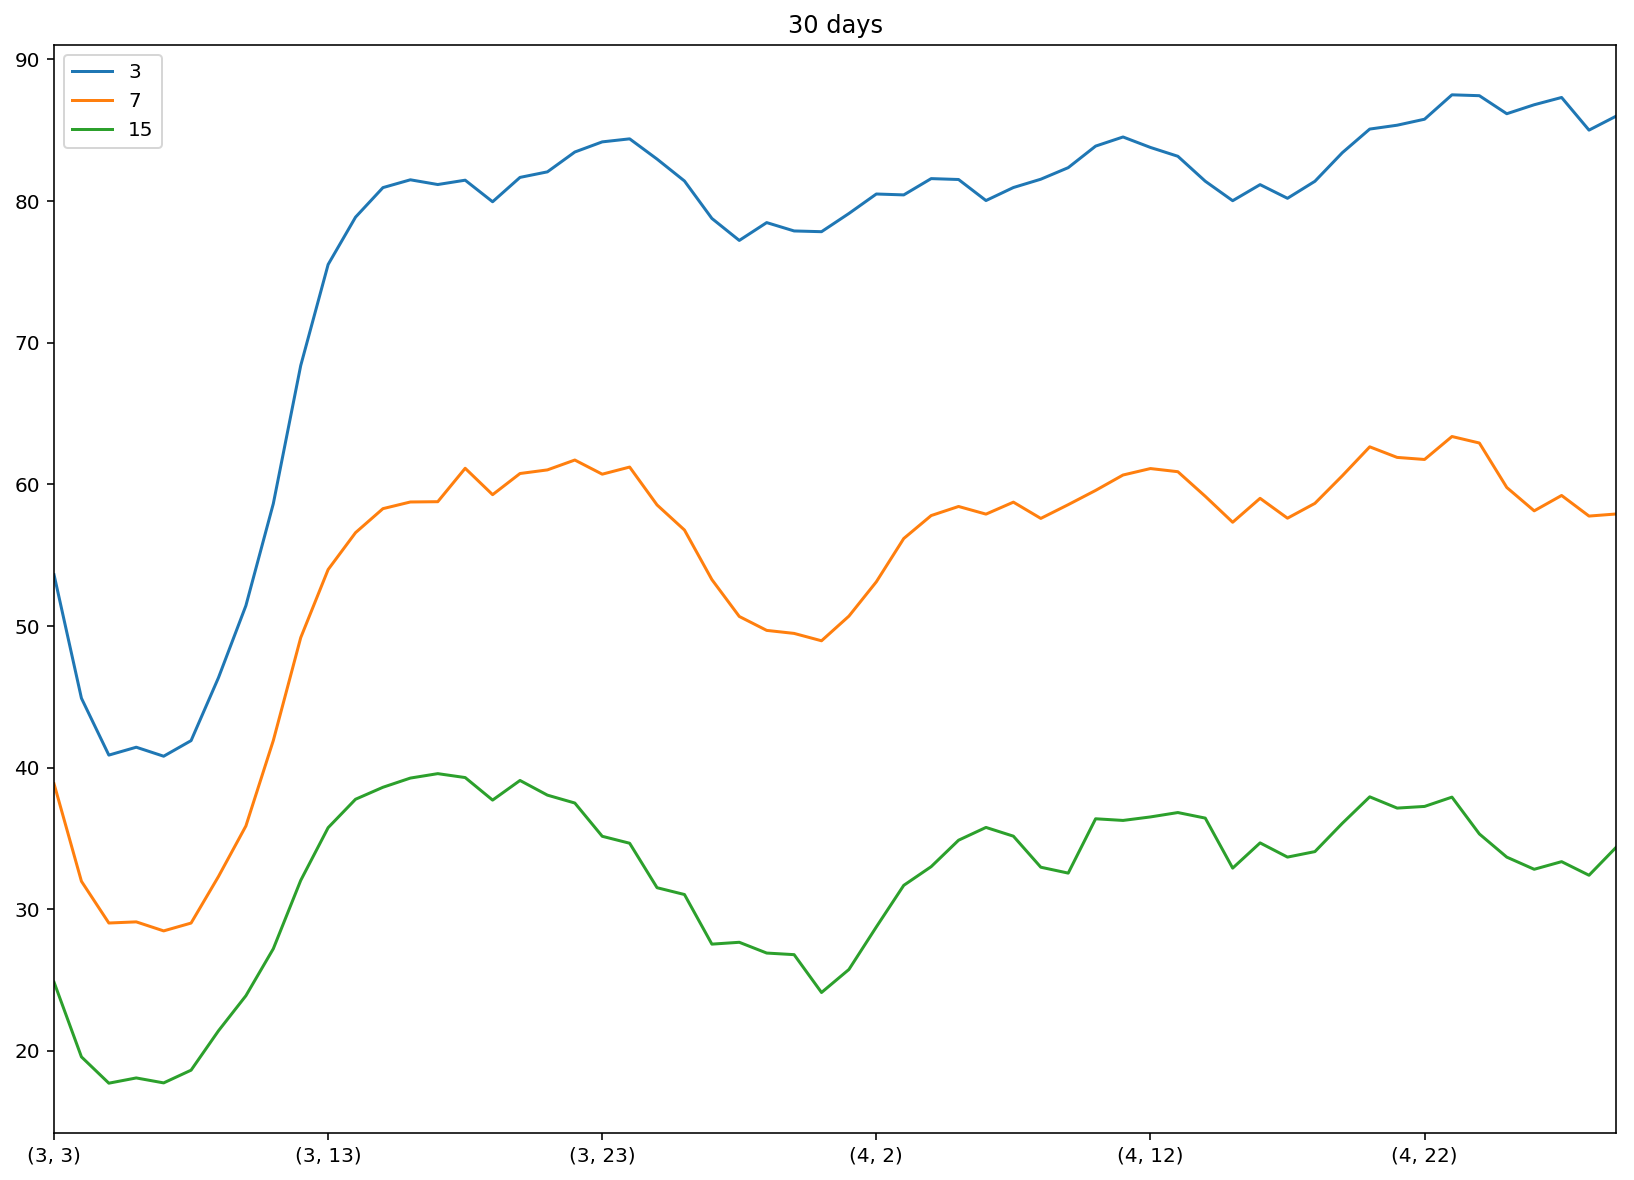

In [91]:
dfs[1].rolling(5,center=True).mean().dropna().plot()
ax=plt.gca()
ax.set_title("30 days")

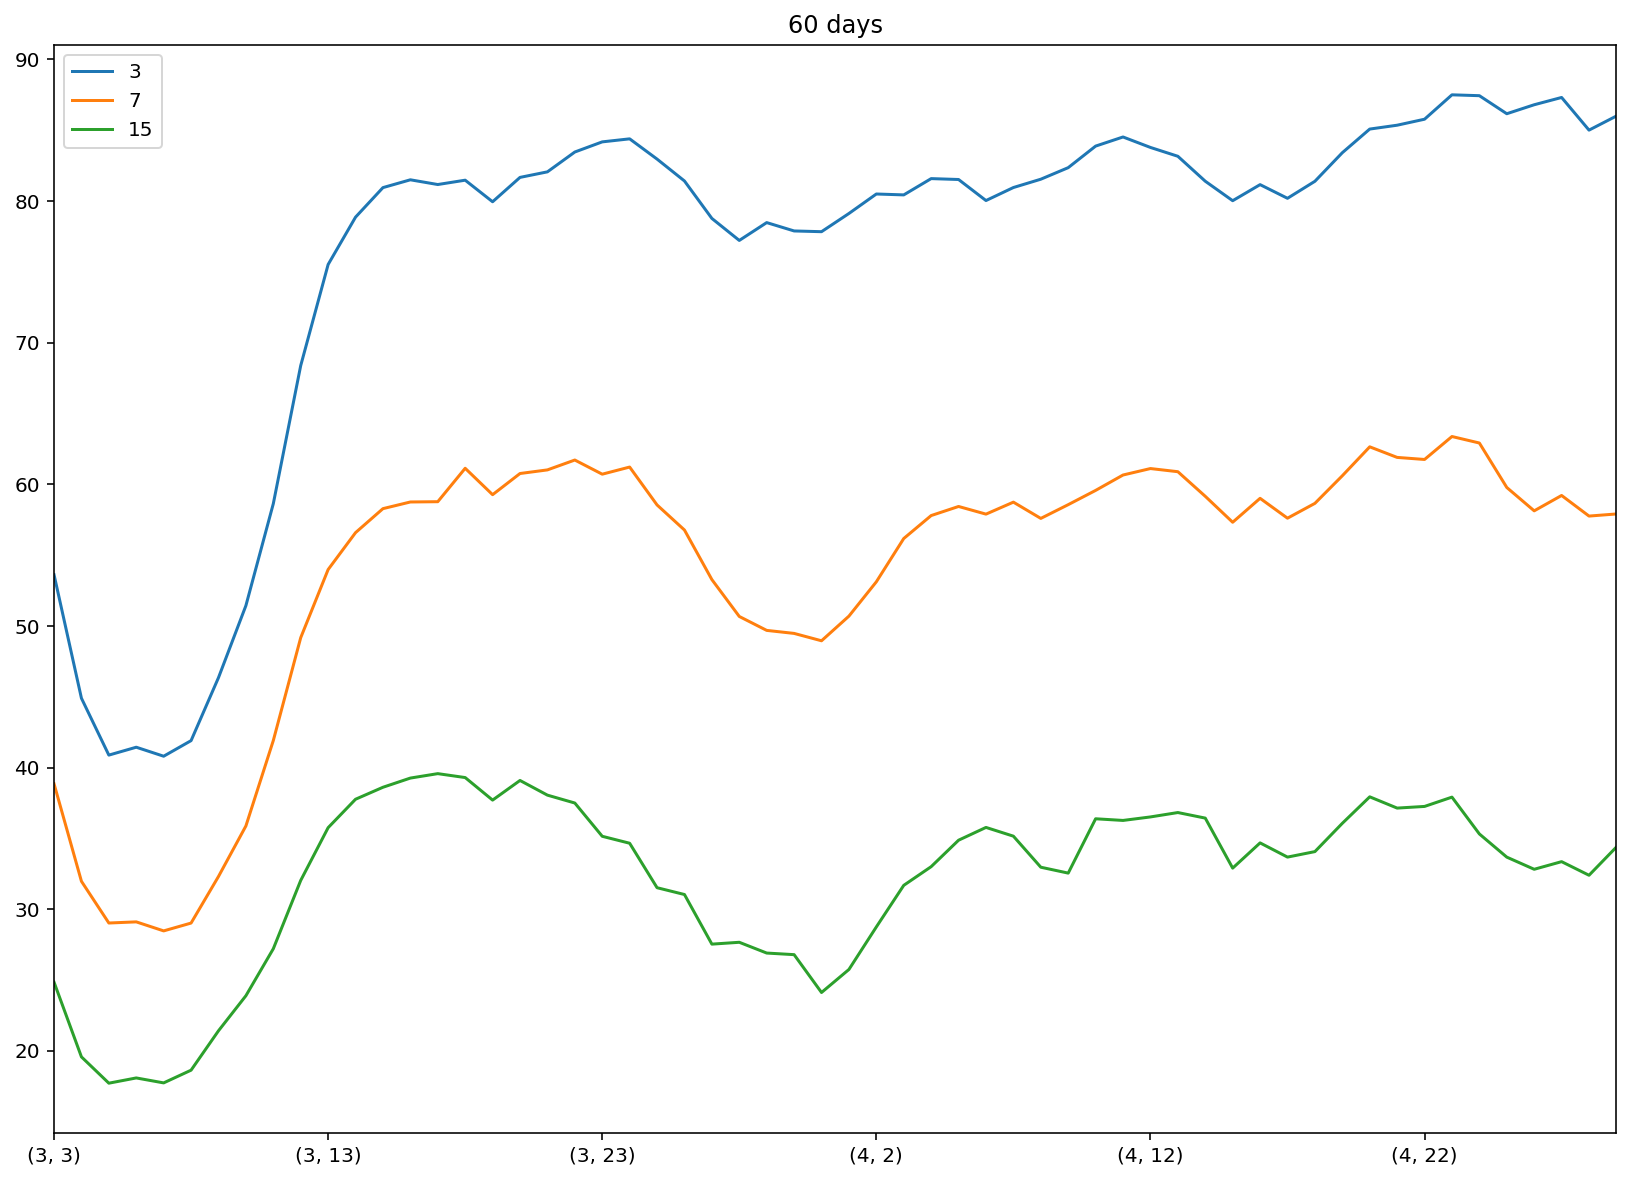

In [92]:
dfs[1].rolling(5,center=True).mean().dropna().plot()
ax=plt.gca()
ax.set_title("60 days")

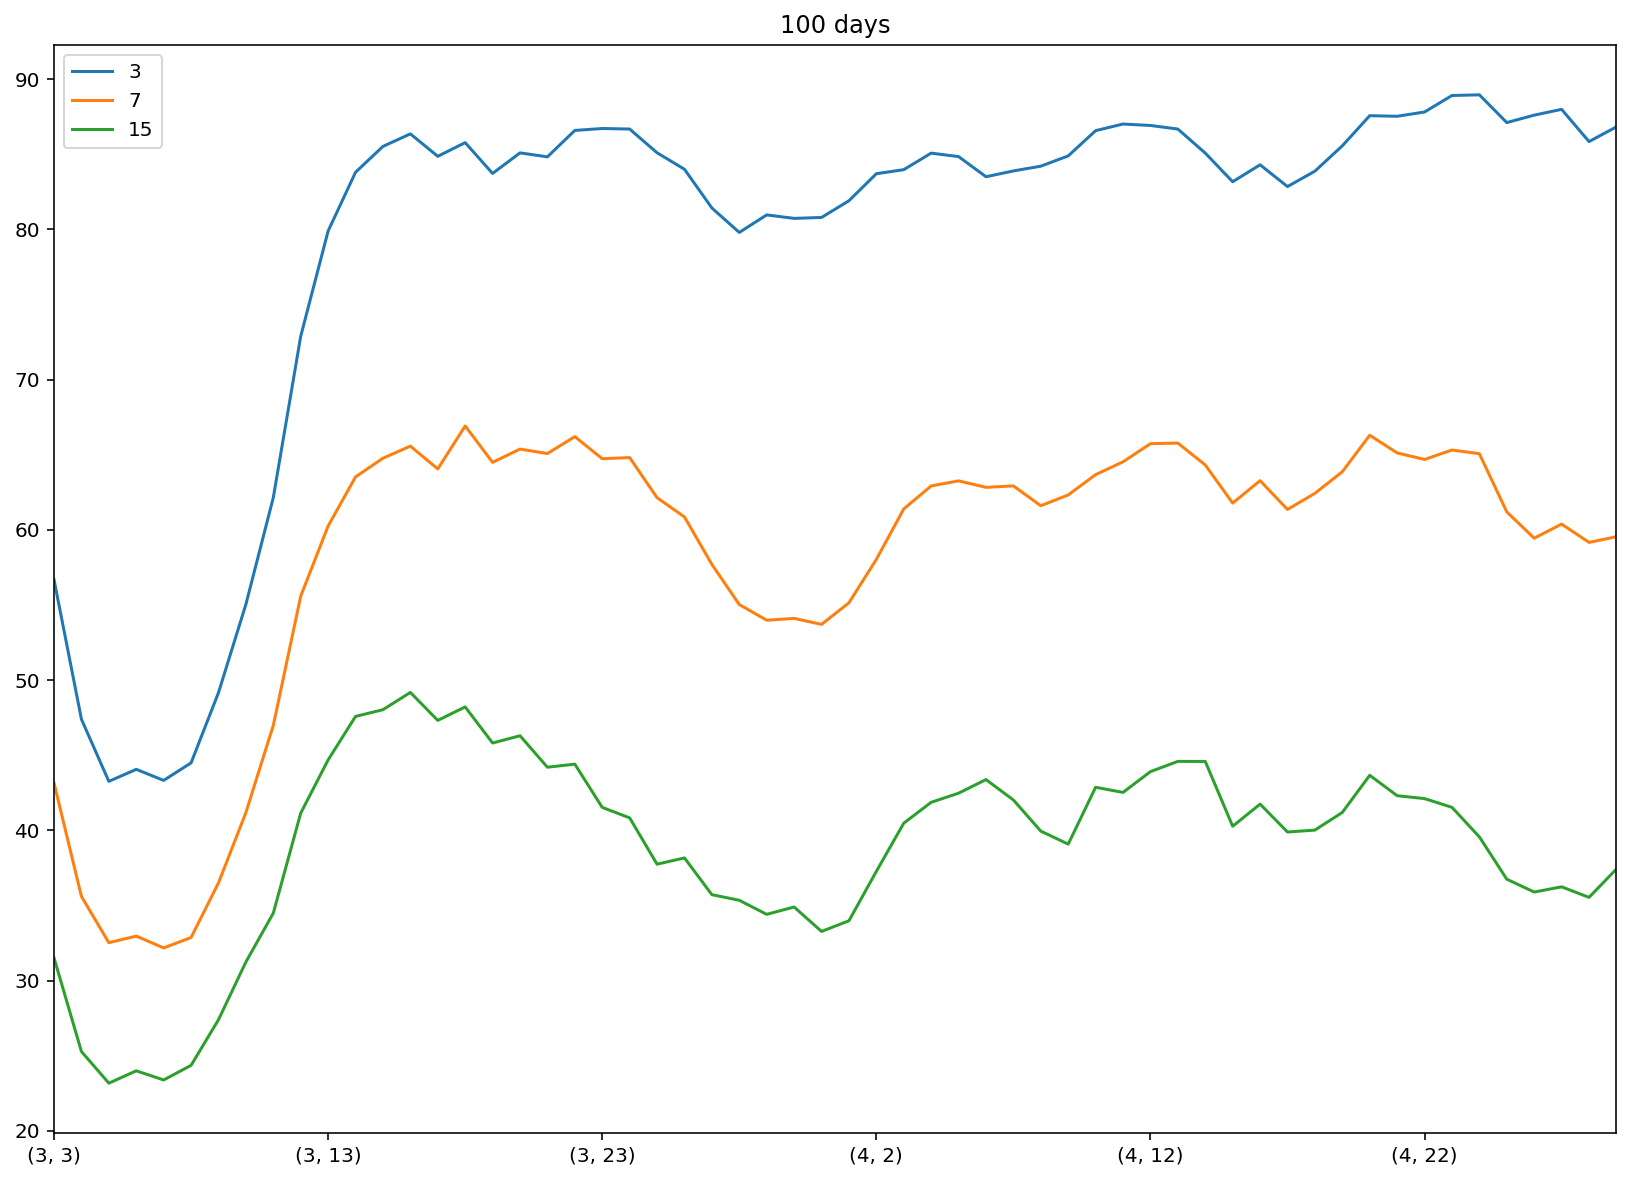

In [93]:
dfs[3].rolling(5,center=True).mean().dropna().plot()
ax=plt.gca()
ax.set_title("100 days")